In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 25, 16
rcParams['legend.fontsize'] = 15
rcParams['axes.titlesize'] = 100
rcParams['axes.labelsize'] = 25

fontsize_par = 10

In [2]:
def split_on_weeks(x, min_date):
    mind = datetime.strptime(min_date, "%Y-%m-%d") 
    xd = datetime.strptime(x, "%Y-%m-%d") 
    a = str(mind + timedelta(days = int((xd - mind).days / 7)*7))[:10] + ' TO ' + str(mind + timedelta(days = 6 + int((xd - mind).days / 7)*7))[:10]
    return a

In [3]:
df_payments_notref_android = pd.read_csv('data/180321_notref_android.csv')
df_payments_ref_android = pd.read_csv('data/180321_ref_android.csv')
df_payments_notref_ios= pd.read_csv('data/180321_notref_ios.csv')
df_payments_ref_ios = pd.read_csv('data/180321_ref_ios.csv')

In [4]:
# df_payments_notref_ios= pd.read_csv('data/payments-1521650507.csv')

In [5]:
df_payments_notref_android['ref'] = 'notref'
df_payments_ref_android['ref'] = 'ref'
df_payments_notref_ios['ref'] = 'notref'
df_payments_ref_ios['ref'] = 'ref'

df_payments_notref_android['app'] = 'android'
df_payments_ref_android['app'] = 'android'
df_payments_notref_ios['app'] = 'ios'
df_payments_ref_ios['app'] = 'ios'

df_payments = df_payments_notref_android.append(df_payments_ref_android).append(df_payments_notref_ios).append(df_payments_ref_ios)

In [6]:
# https://portraits.core.tf/goto/997bac2ac0c91bc01385cfc197c8e4c7
df_installs_all = pd.read_csv('data/180321_installs.csv', thousands=',')
df_installs_all.columns = ['created per day','ref','app','users']
df_installs_all['created per day'] = df_installs_all['created per day'].map(lambda x: x[:10])
dict_app = {'first_app:topfacemobappandroid': 'android','first_app:topfacemobappios':'ios'}
dict_ref = {'referral:0': 'notref','referral:1':'ref'}
df_installs_all['app'] = df_installs_all['app'].map(dict_app)
df_installs_all['ref'] = df_installs_all['ref'].map(dict_ref)

In [7]:
# min_data = "2017-12-07"
# max_date = "2018-03-01"
min_date = "2018-01-01"
max_date = "2018-03-01"

In [8]:
df_payments['days from reg'] = df_payments['payment date'].map(lambda x: datetime.strptime(x[:10], "%Y-%m-%d")) - df_payments['registration date'].map(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
df_payments['days from reg'] = df_payments['days from reg'].map(lambda x: x.days)
df_payments['weeks from reg'] = df_payments['days from reg'].map(lambda x: int(x / 7))
df_payments['registration day'] = df_payments['registration date'].map(lambda x: x[:10])
df_payments['payment day'] = df_payments['payment date'].map(lambda x: x[:10])

df_payments = df_payments[df_payments['days from reg'] <= 21]

df_installs_all['created week'] = df_installs_all['created per day'].map(lambda x: split_on_weeks(x, min_date) )


df_payments['registration week'] = df_payments['registration day'].map(lambda x: split_on_weeks(x, min_date) )


df_payments['registration month'] = df_payments['registration date'].map(lambda x: x[:7])
df_installs_all['created month'] =  df_installs_all['created per day'].map(lambda x: x[:7])

In [9]:
# df_installs_all = df_installs_all[df_installs_all['created per day'] < '2018-03-15']
# df_payments = df_payments[df_payments['registration date'] < '2018-03-15']

df_installs_all = df_installs_all[df_installs_all['created per day'] < max_date]
df_payments = df_payments[df_payments['registration date'] < max_date]

df_installs_all = df_installs_all[df_installs_all['created per day'] >= min_date]
df_payments = df_payments[df_payments['registration date'] >= min_date]

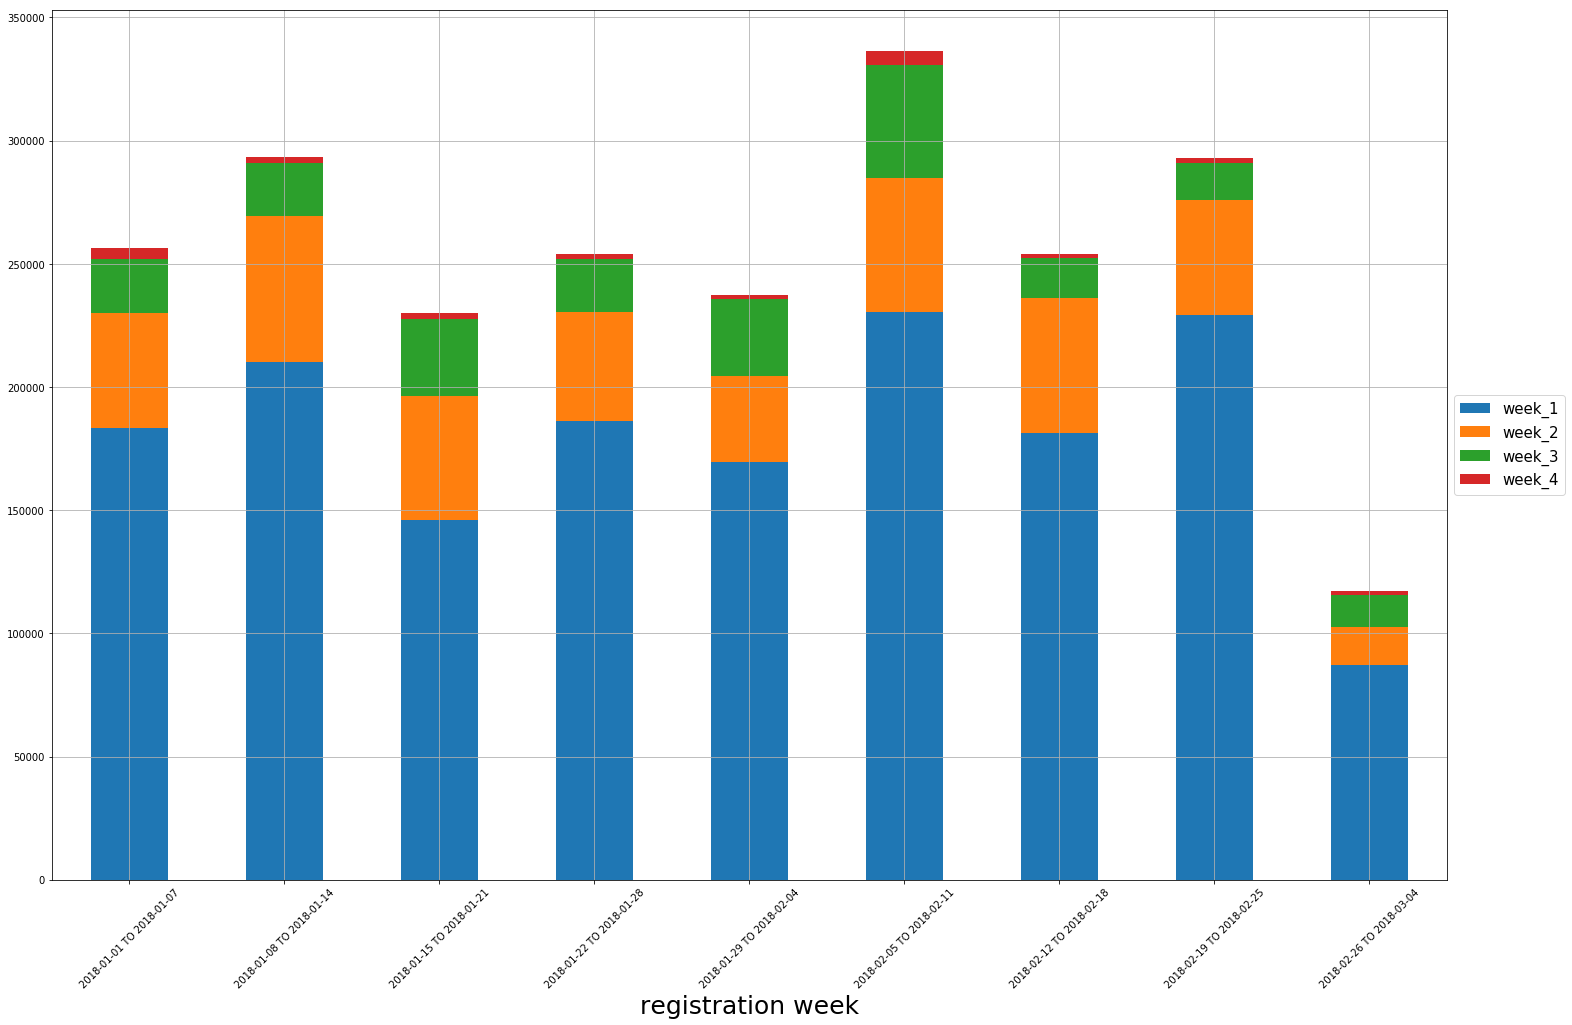

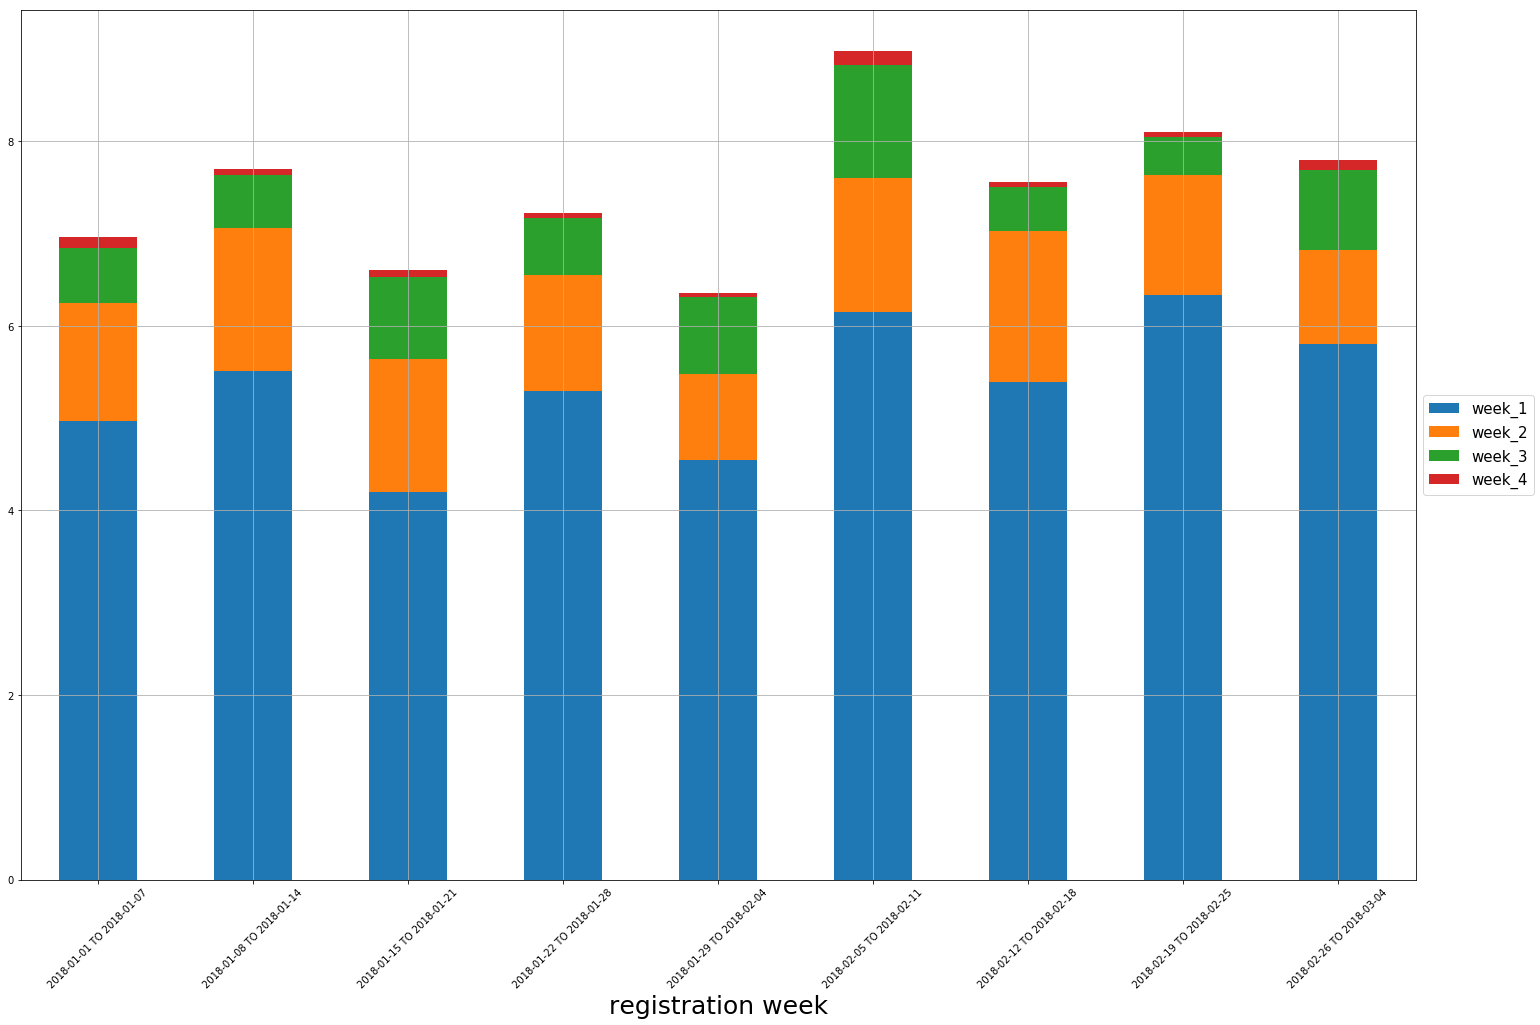

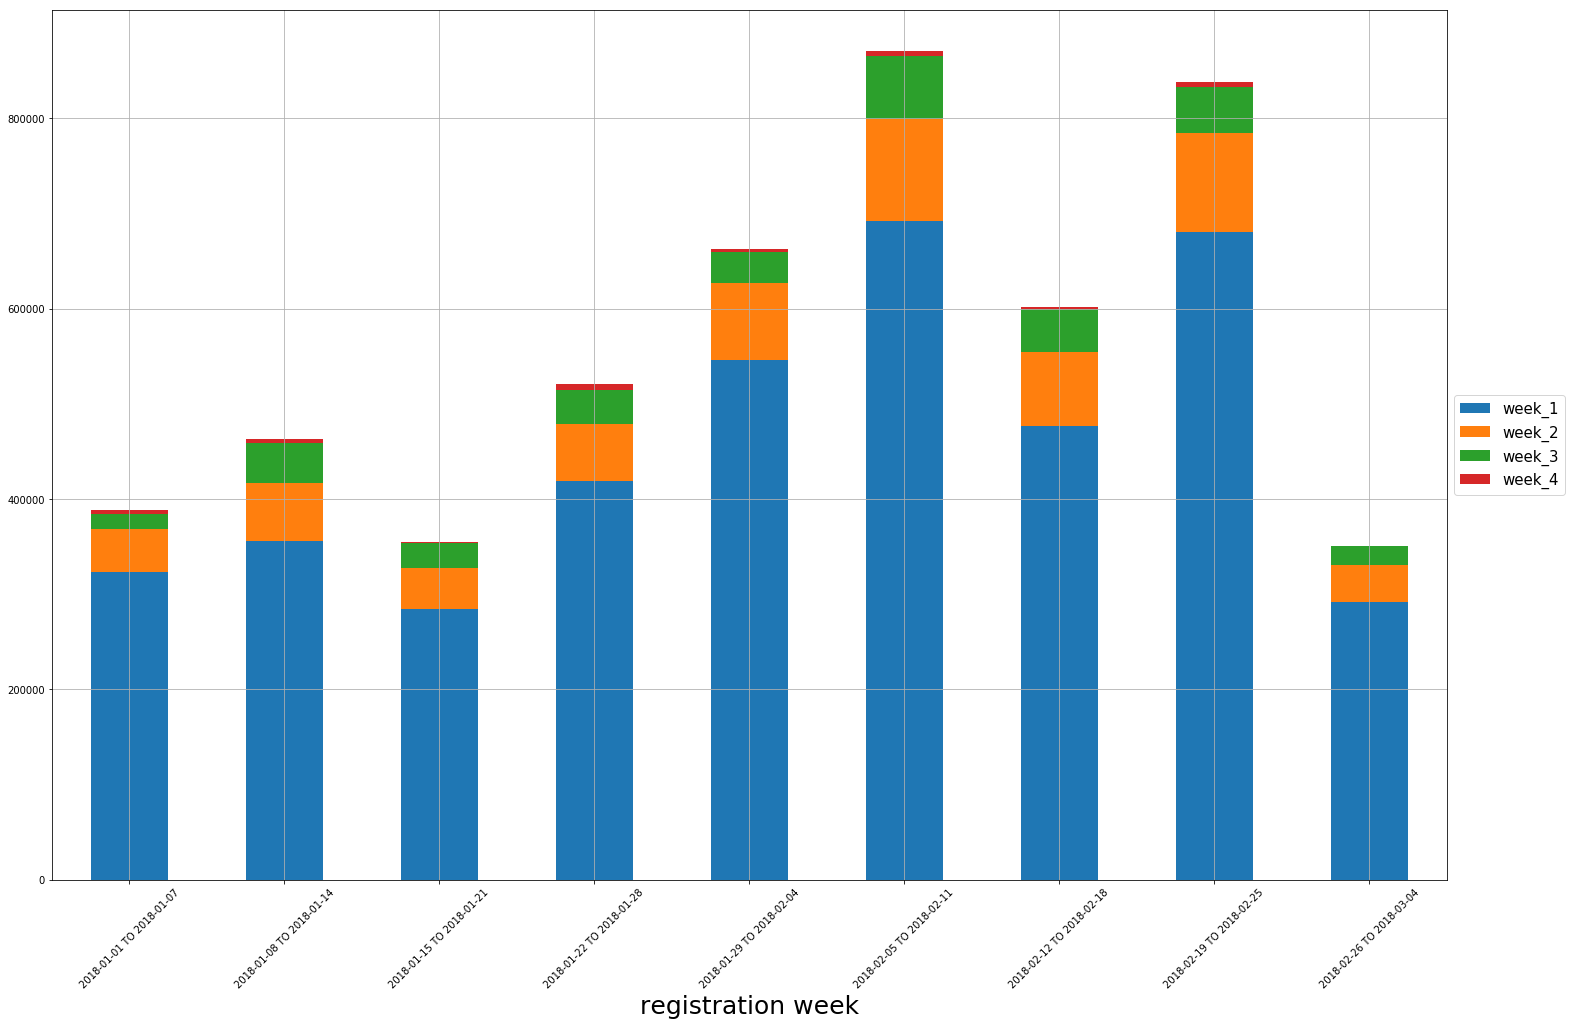

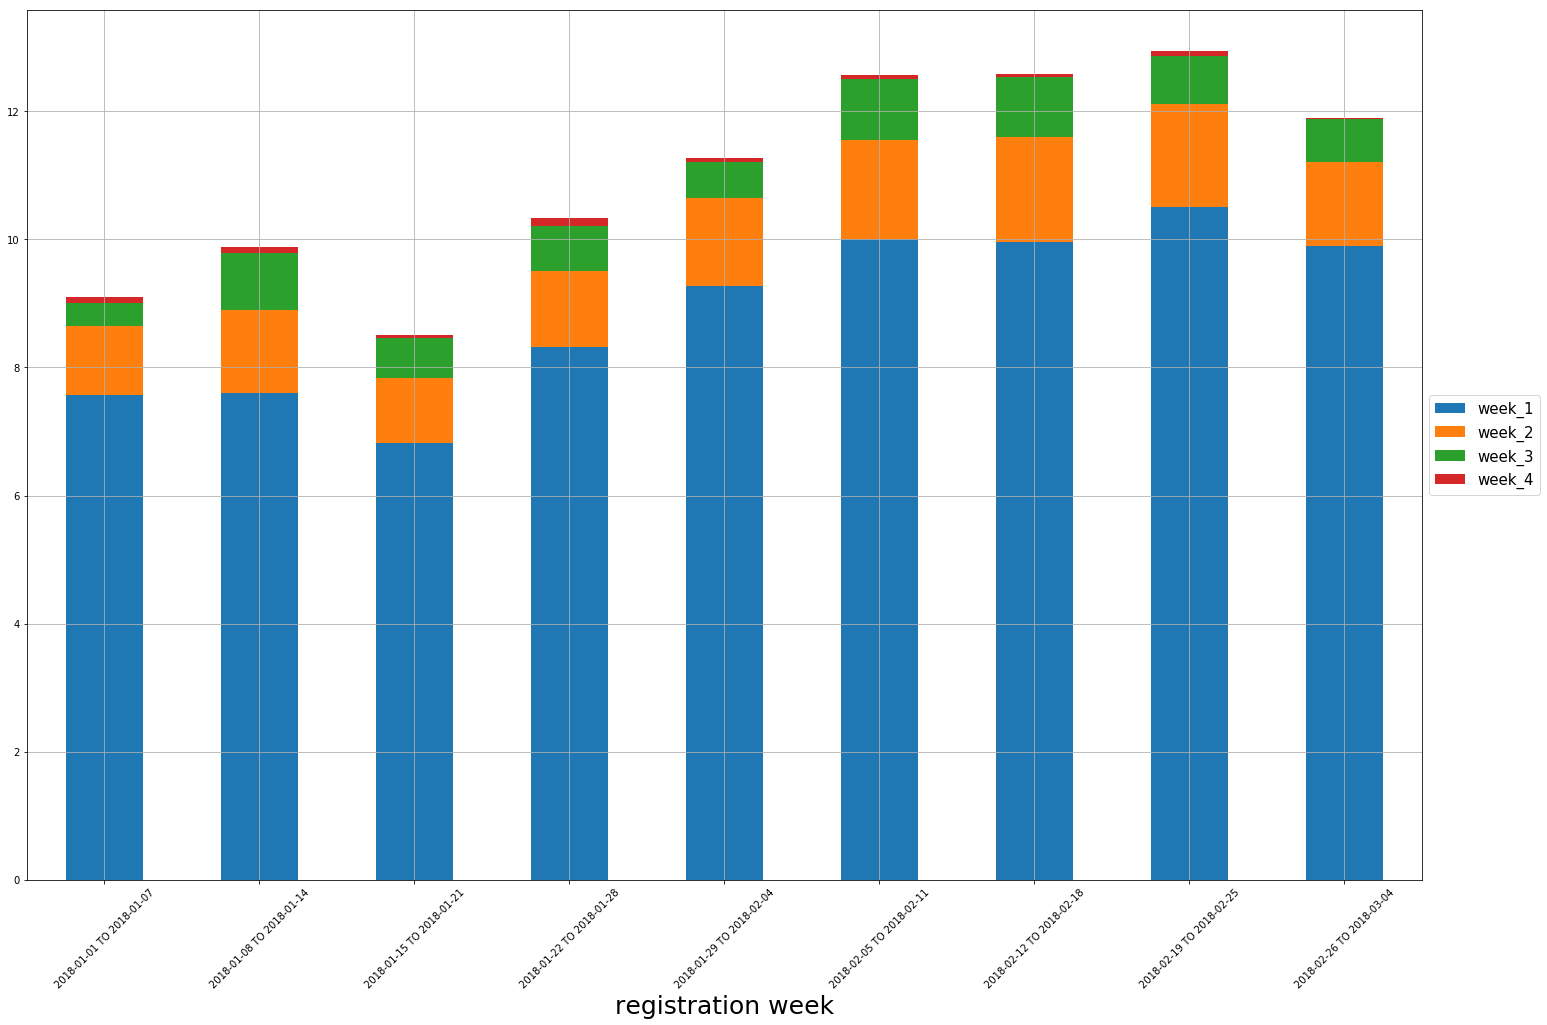

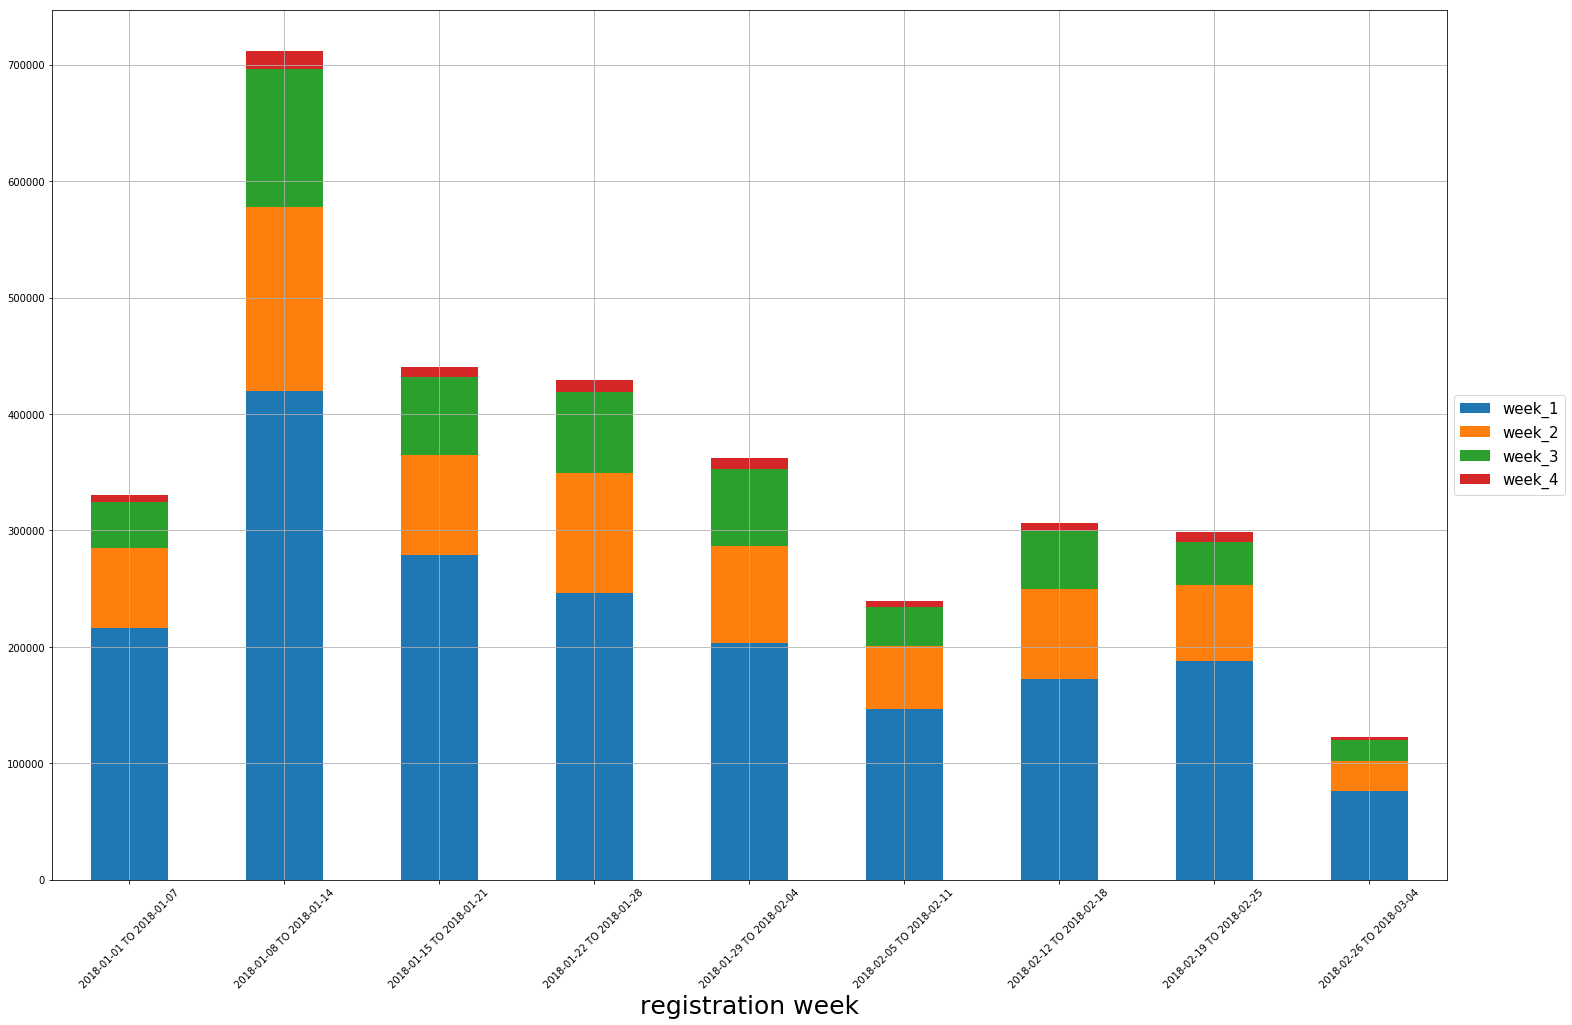

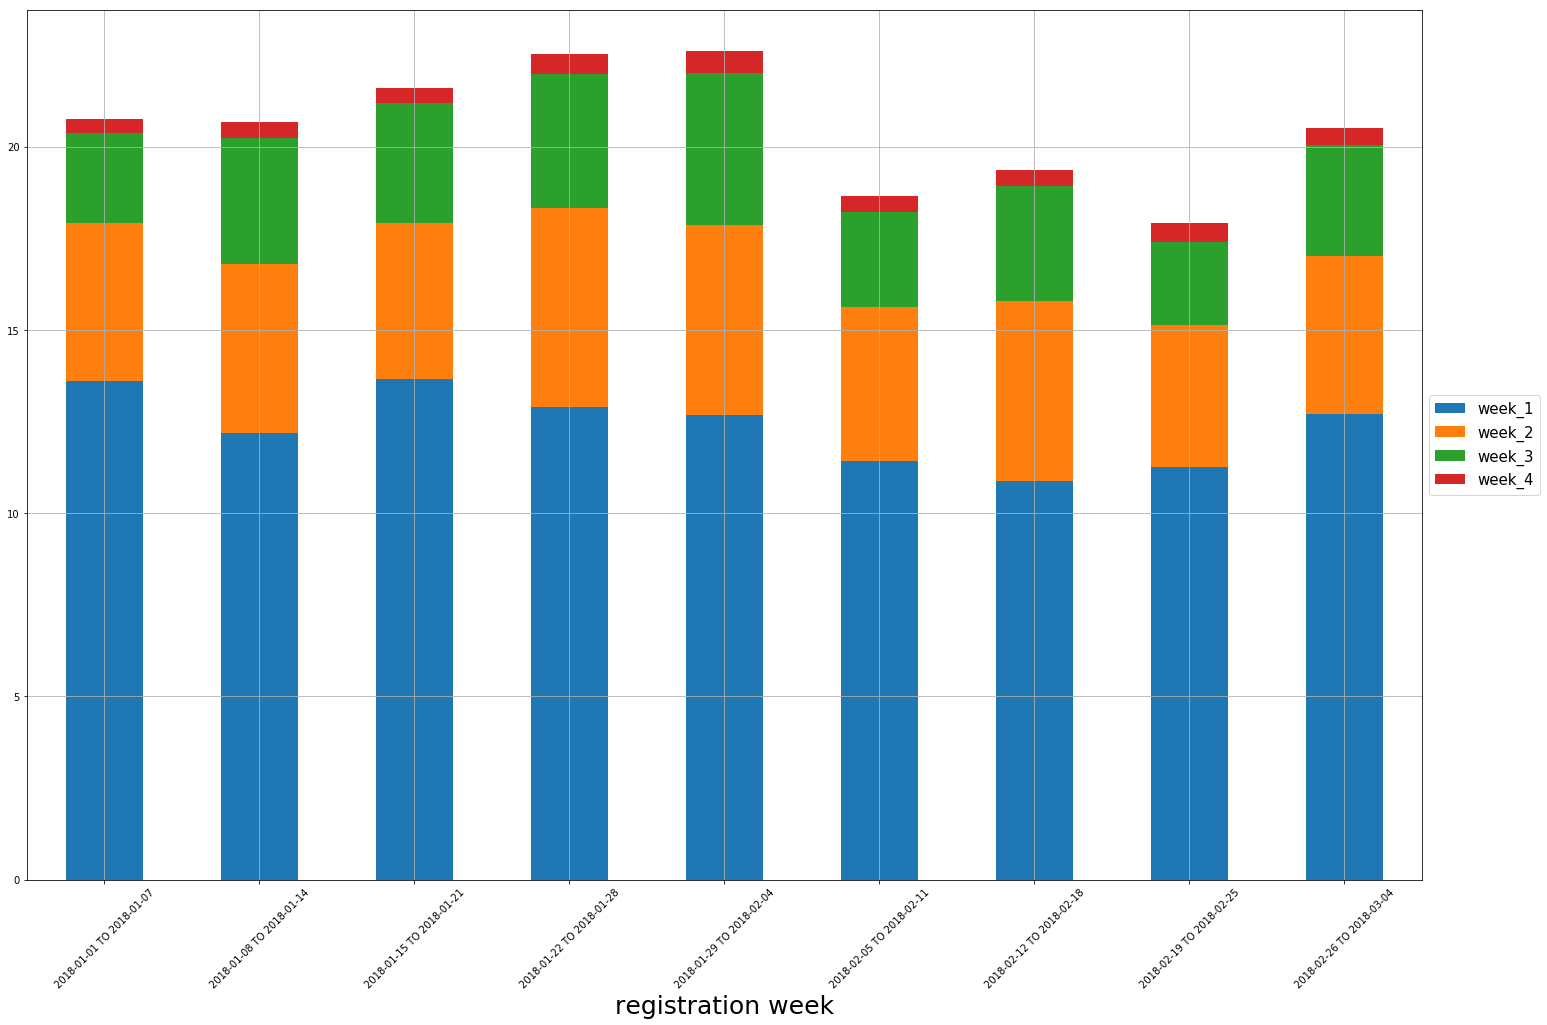

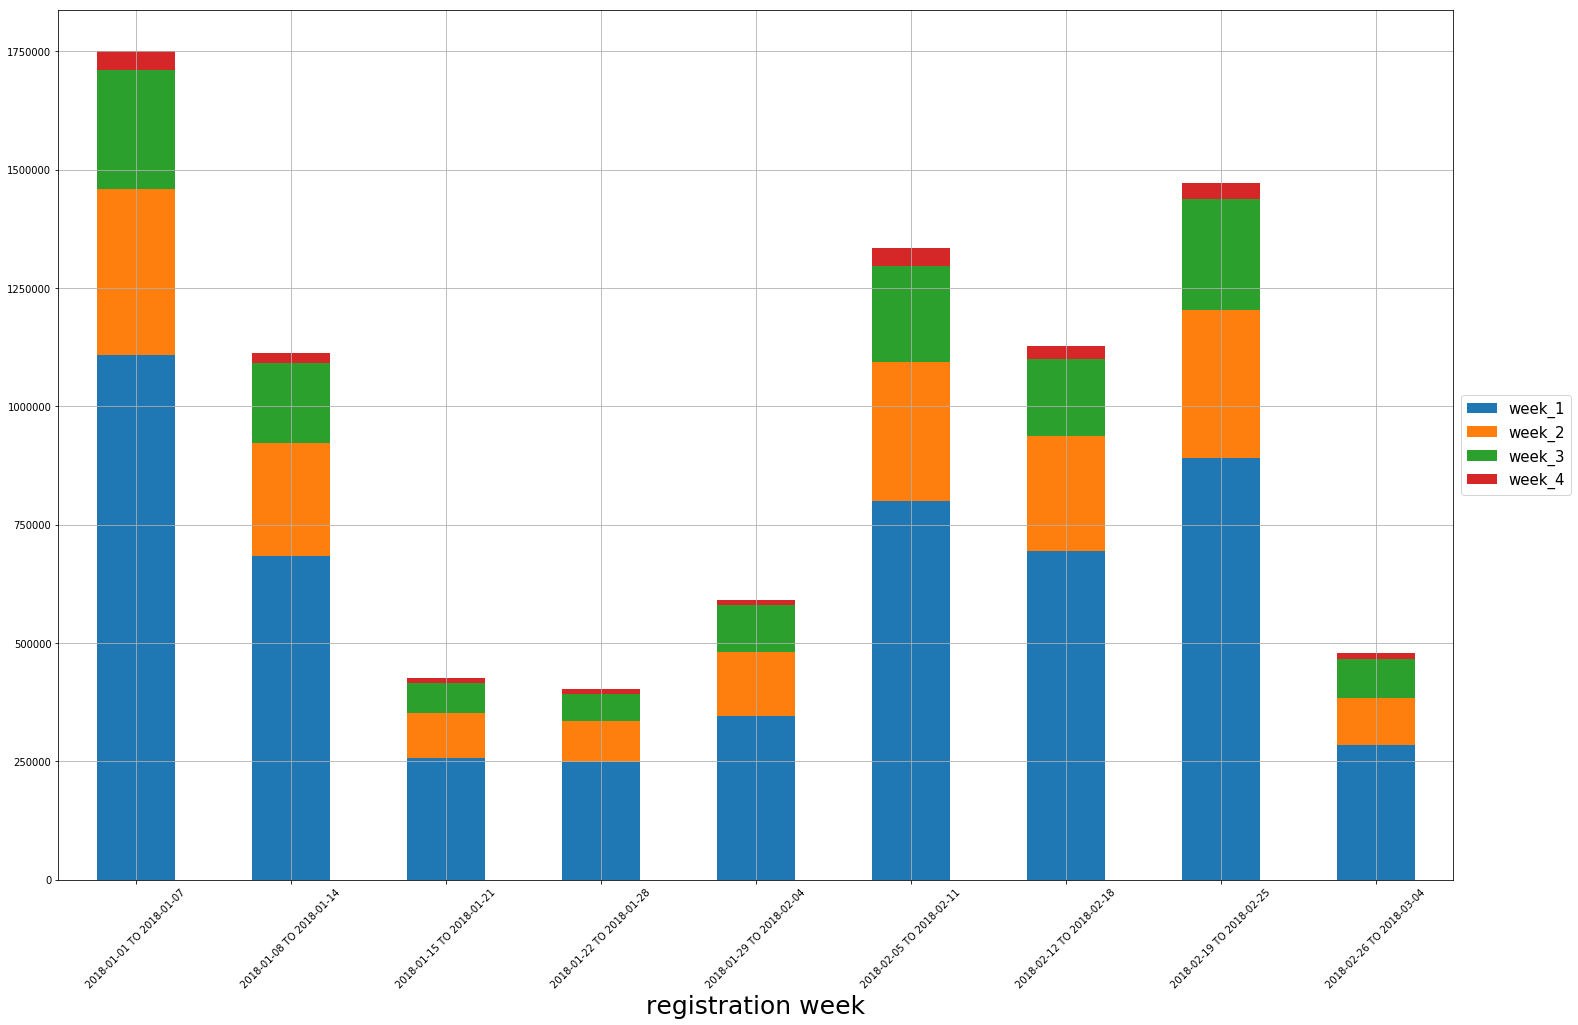

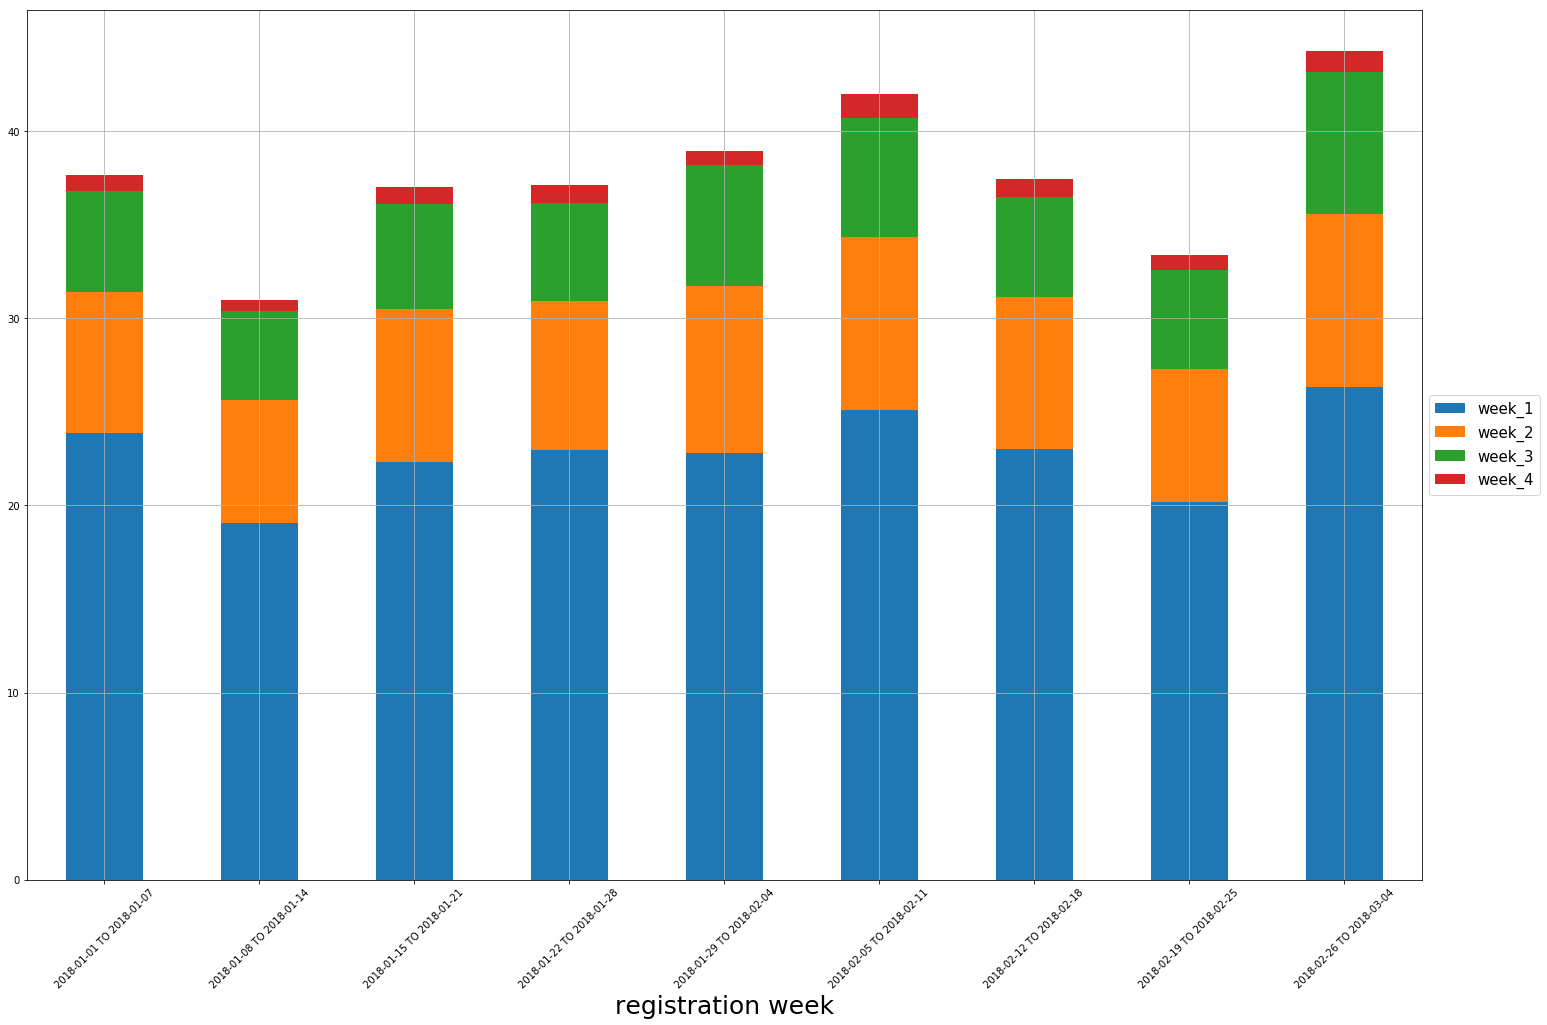

In [11]:
writer = pd.ExcelWriter('out/revenue_by_days.xlsx')
for app in ['android','ios']:
    for ref in ['notref','ref']:
        df = df_payments[(df_payments['app'] == app) & (df_payments['ref'] == ref)]
        df_installs = df_installs_all[(df_installs_all['app'] == app) & (df_installs_all['ref'] == ref)]
        df_installs_2 = df_installs.groupby('created week')['users'].sum()
        m_revenue = df.pivot_table(index='registration week', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
        m_revenue.columns = ['week_1','week_2','week_3','week_4']     
        daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
        m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
        daily_metrics.to_excel(writer,'revenue' + ref+'_'+app)
        m_revenue_normed.to_excel(writer,'revenue_on_regs' + ref+'_'+app)
        daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
        vars()['m_revenue_'+ref+'_'+app] = m_revenue
        vars()['m_revenue_normed_'+ref+'_'+app] = m_revenue_normed
        vars()['daily_metrics_'+ref+'_'+app] = daily_metrics
        
        m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        plt.savefig('img/revenue_'+ref+'_'+app+'.png')
        
        m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
        plt.savefig('img/normed_revenue_'+ref+'_'+app+'.png')
writer.save()

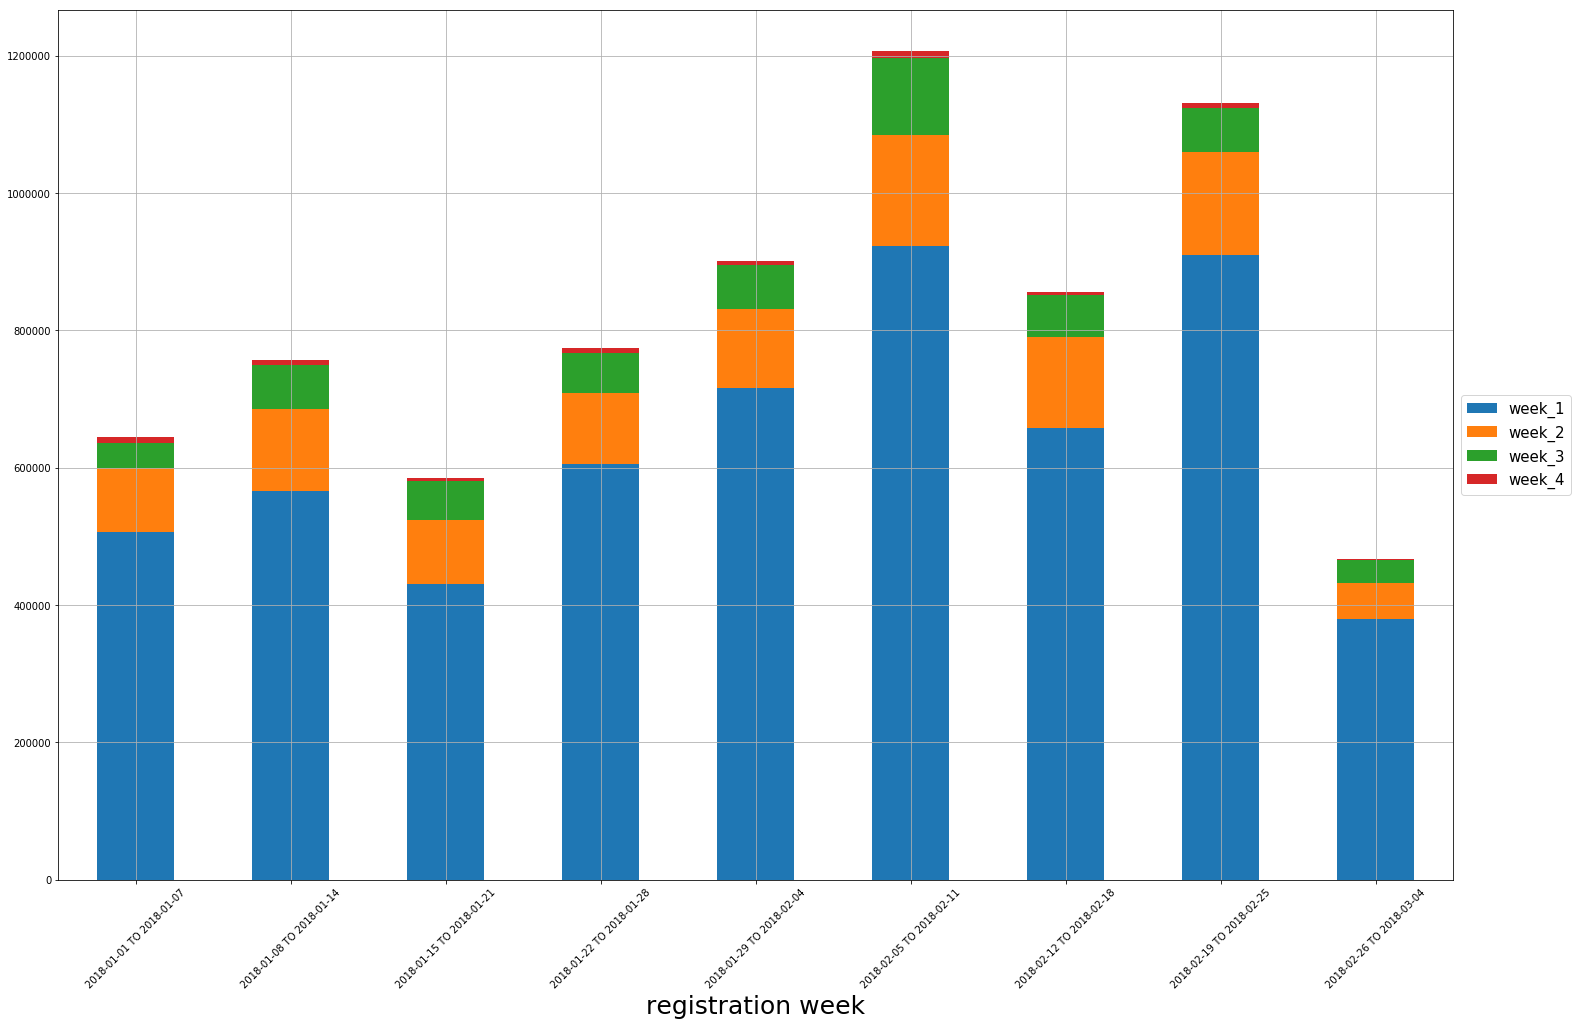

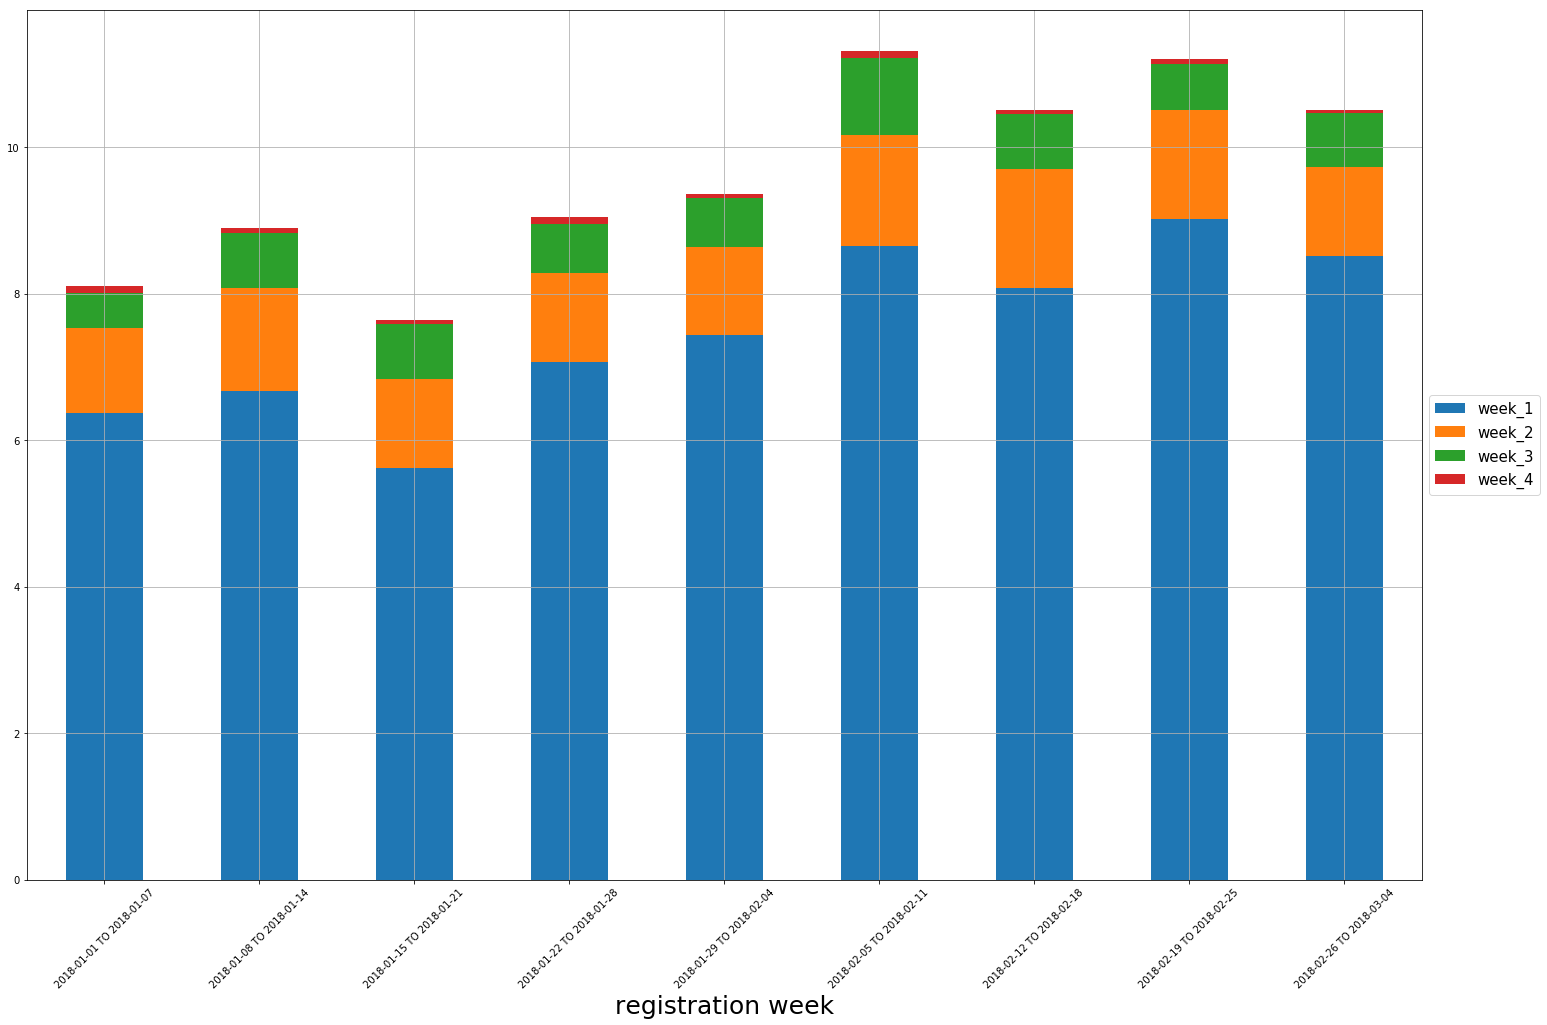

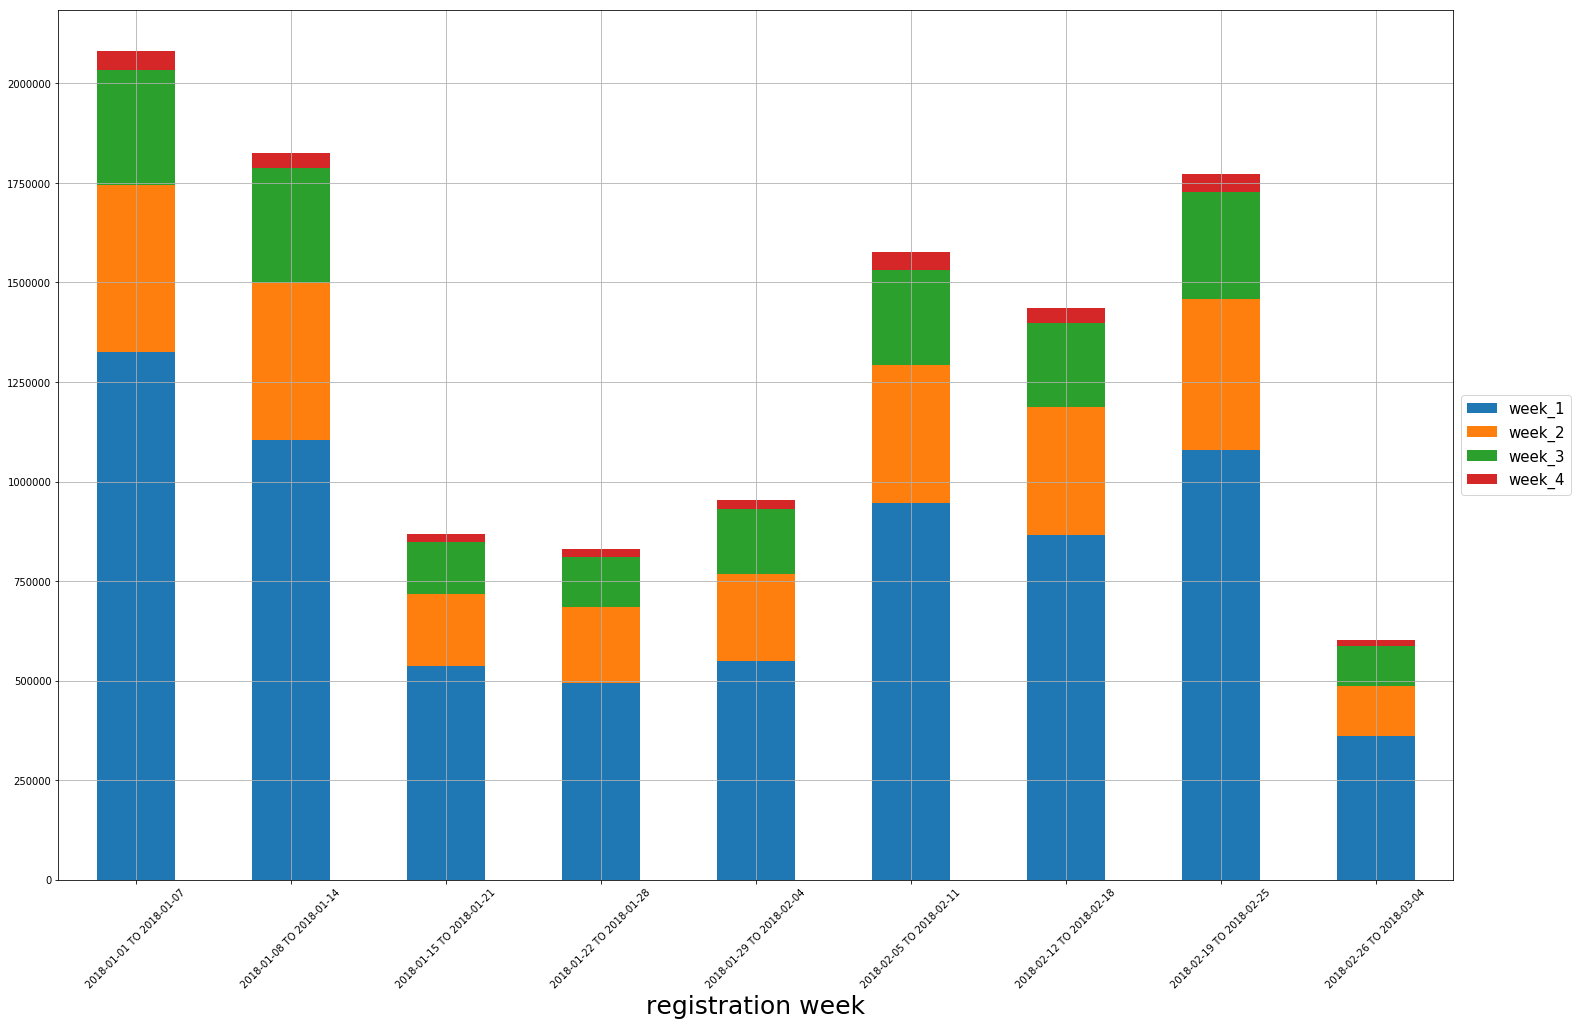

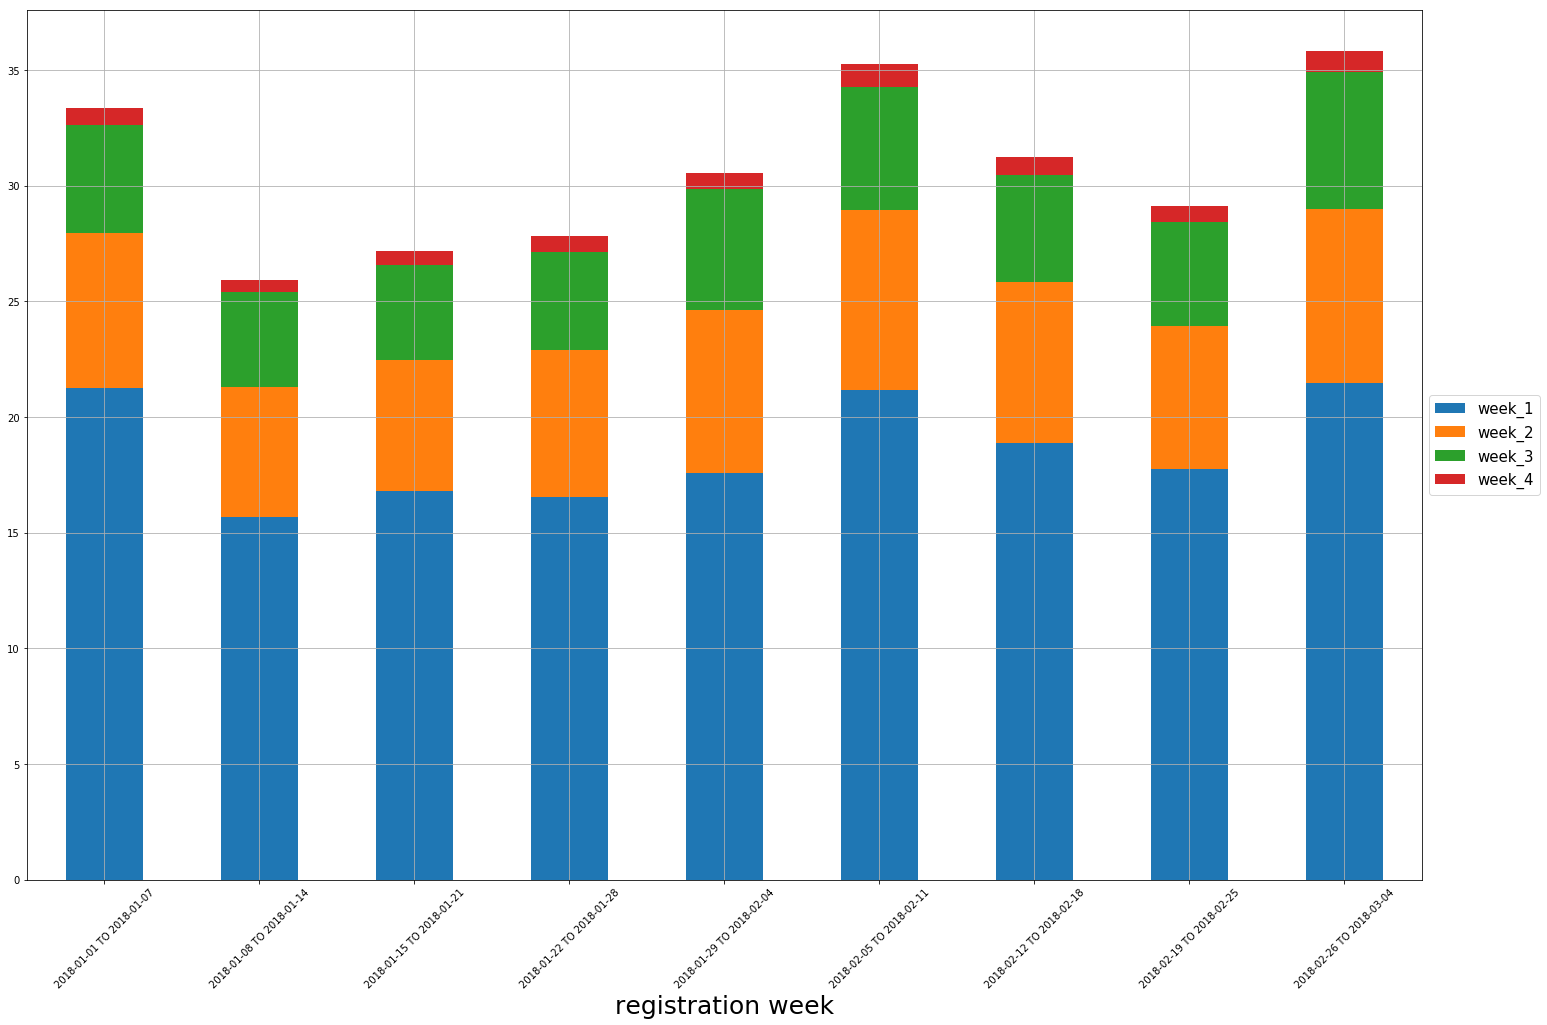

In [12]:
# writer = pd.ExcelWriter('out/revenue_by_days.xlsx')

# for app in ['android','ios']:
#     for ref in ['notref','ref']:
#         df = df_payments[(df_payments['app'] == app) & (df_payments['ref'] == ref)]
#         df_installs = df_installs_all[(df_installs_all['app'] == app) & (df_installs_all['ref'] == ref)]
#         df_installs_2 = df_installs.groupby('created week')['users'].sum()
#         m_revenue = df.pivot_table(index='registration week', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
#         m_revenue.columns = ['week_1','week_2','week_3','week_4']     
#         daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
#         m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
#         daily_metrics.to_excel(writer,'revenue' + ref+'_'+app)
#         m_revenue_normed.to_excel(writer,'revenue_on_regs' + ref+'_'+app)
#         daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
#         vars()['m_revenue_'+ref+'_'+app] = m_revenue
#         vars()['m_revenue_normed_'+ref+'_'+app] = m_revenue_normed
#         vars()['daily_metrics_'+ref+'_'+app] = daily_metrics
        
#         m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img/revenue_'+ref+'_'+app+'.png')
        
#         m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img/normed_revenue_'+ref+'_'+app+'.png')

# for app in ['android','ios']:
#         df = df_payments[(df_payments['app'] == app)]
#         df_installs = df_installs_all[(df_installs_all['app'] == app)]
#         df_installs_2 = df_installs.groupby('created week')['users'].sum()
#         m_revenue = df.pivot_table(index='registration week', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
#         m_revenue.columns = ['week_1','week_2','week_3','week_4']
#         daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
#         m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
#         daily_metrics.to_excel(writer,'revenue'+'_'+app)
#         m_revenue_normed.to_excel(writer,'revenue_on_regs'+'_'+app)
#         daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
#         vars()['m_revenue_'+app] = m_revenue
#         vars()['m_revenue_normed_'+app] = m_revenue_normed
#         vars()['daily_metrics_'+app] = daily_metrics
        
#         m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img/revenue_'+app+'.png')
        
#         m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img/normed_revenue_'+app+'.png')

# for ref in ['notref','ref']:
#         df = df_payments[(df_payments['ref'] == ref)]
#         df_installs = df_installs_all[(df_installs_all['ref'] == ref)]
#         df_installs_2 = df_installs.groupby('created week')['users'].sum()
#         m_revenue = df.pivot_table(index='registration week', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
#         m_revenue.columns = ['week_1','week_2','week_3','week_4']
#         daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
#         m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
#         daily_metrics.to_excel(writer,'revenue'+'_'+ref)
#         m_revenue_normed.to_excel(writer,'revenue_on_regs'+'_'+ref)
#         daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
#         vars()['m_revenue_'+ref] = m_revenue
#         vars()['m_revenue_normed_'+ref] = m_revenue_normed
#         vars()['daily_metrics_'+ref] = daily_metrics
        
#         m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img/revenue_'+ref+'.png')
        
#         m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img/normed_revenue_'+ref+'.png')
        
# df = df_payments
# df_installs = df_installs_all
# df_installs_2 = df_installs.groupby('created week')['users'].sum()
# m_revenue = df.pivot_table(index='registration week', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
# m_revenue.columns = ['week_1','week_2','week_3','week_4']
# daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
# m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
# daily_metrics.to_excel(writer,'revenue')
# m_revenue_normed.to_excel(writer,'revenue_on_regs')
# daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
# vars()['m_revenue'] = m_revenue
# vars()['m_revenue_normed'] = m_revenue_normed
# vars()['daily_metrics'] = daily_metrics
        
# m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.savefig('img/revenue.png')
        
# m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.savefig('img/normed_revenue.png')

# writer.save()

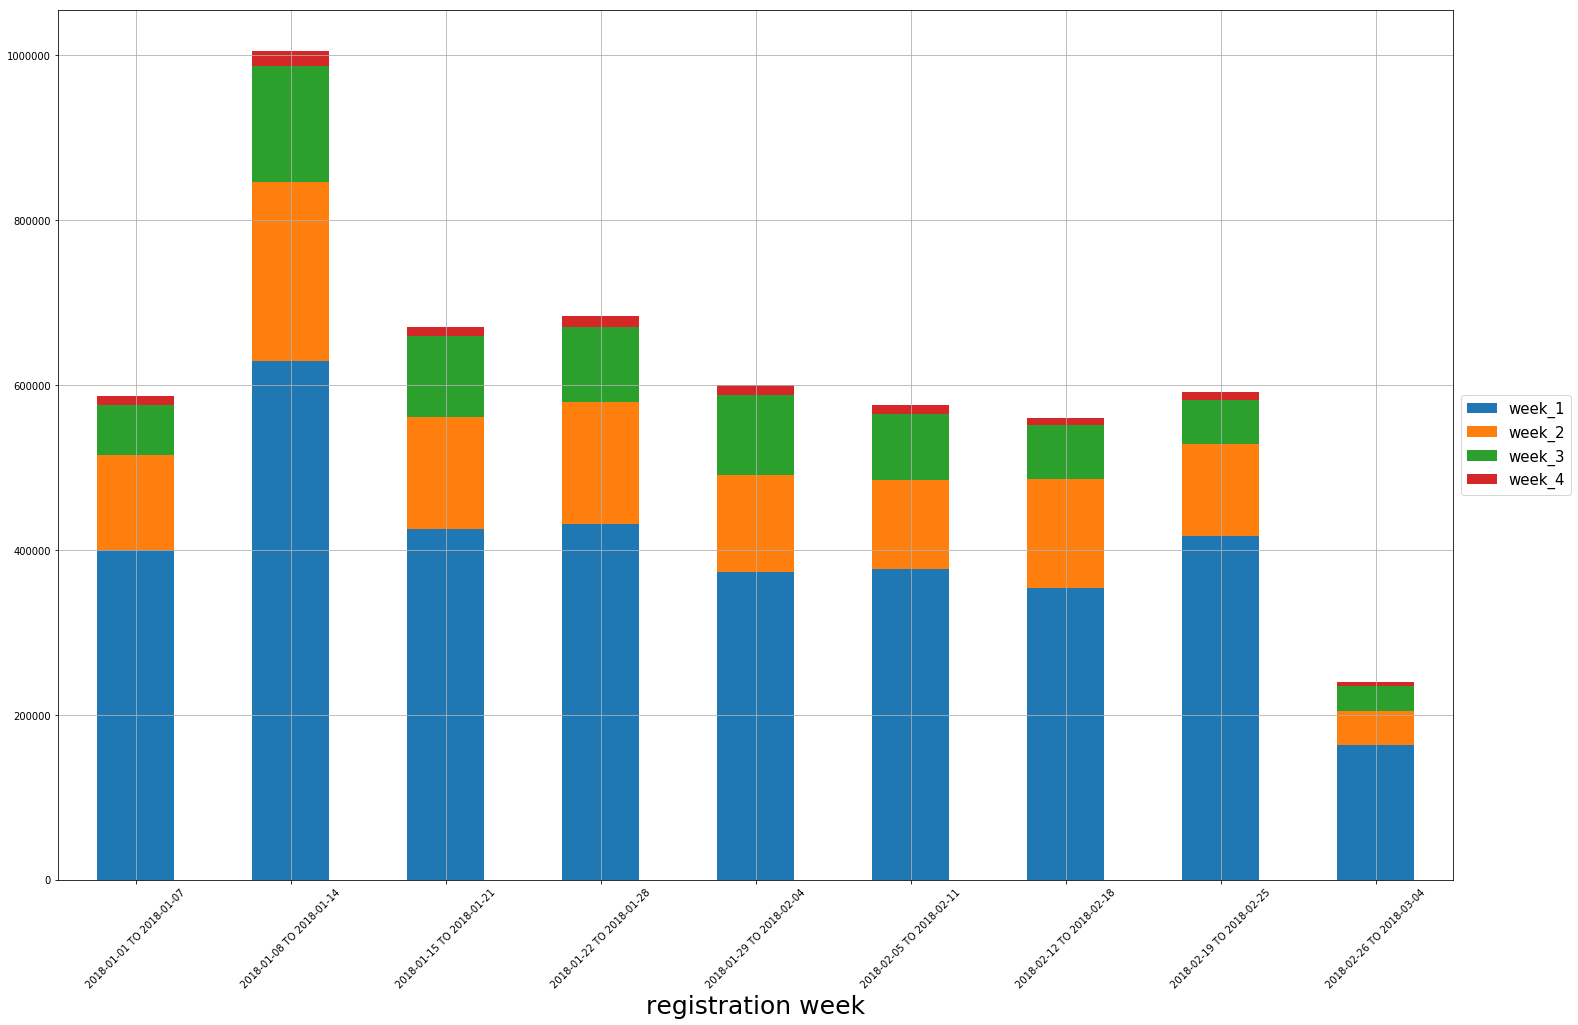

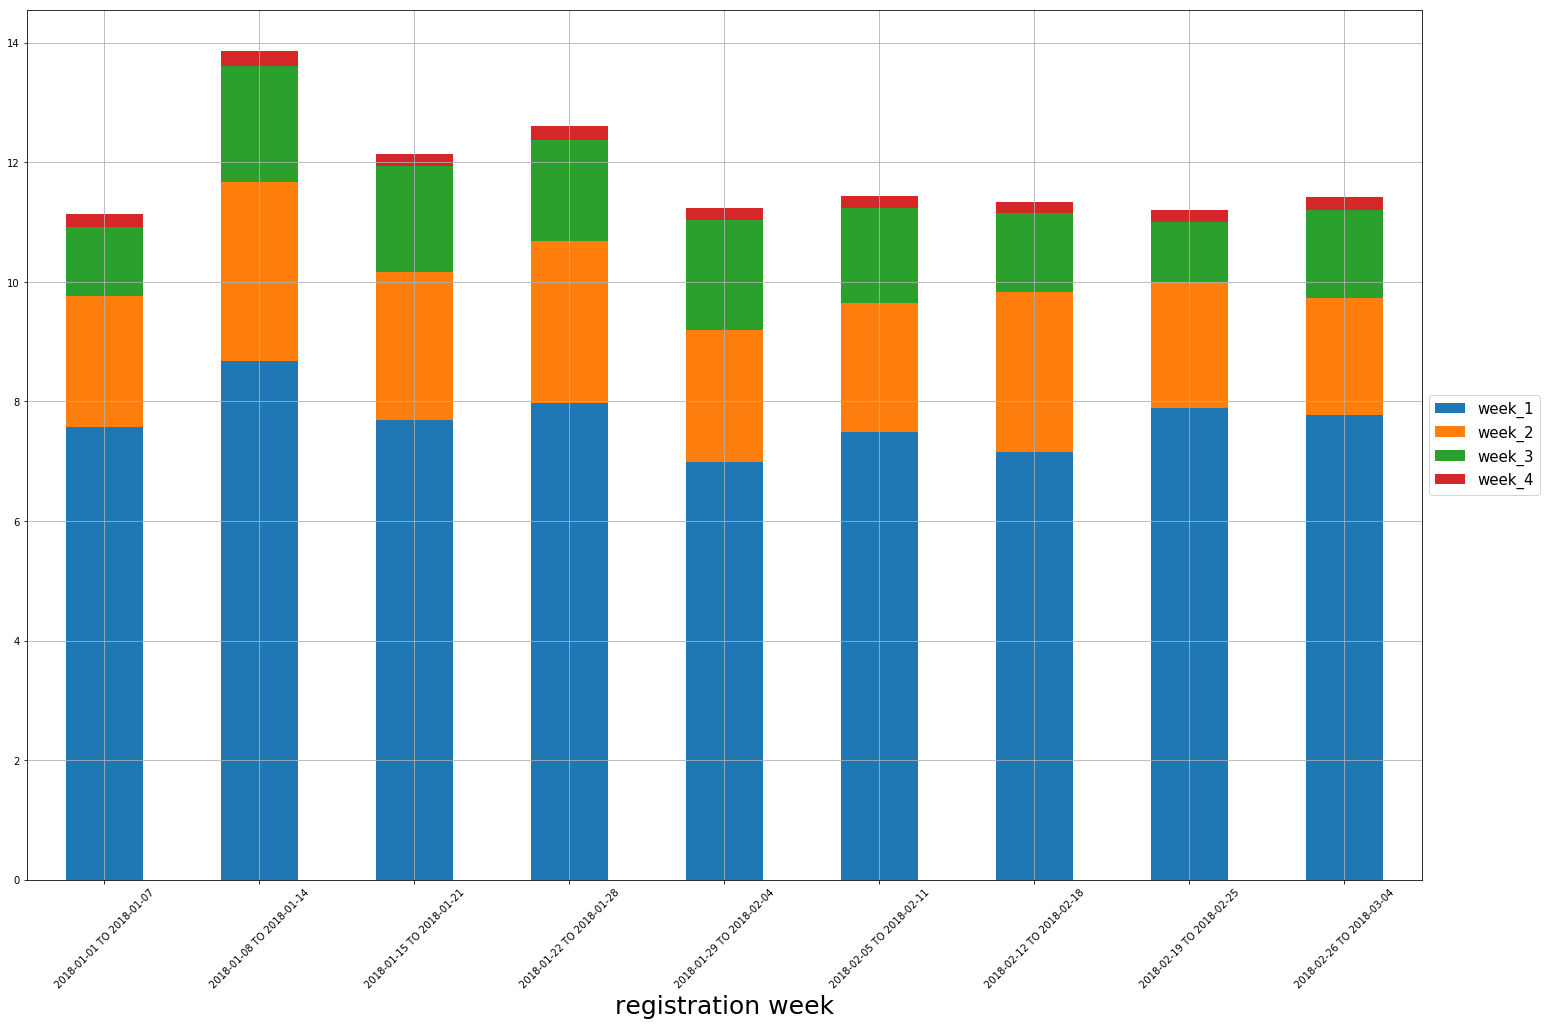

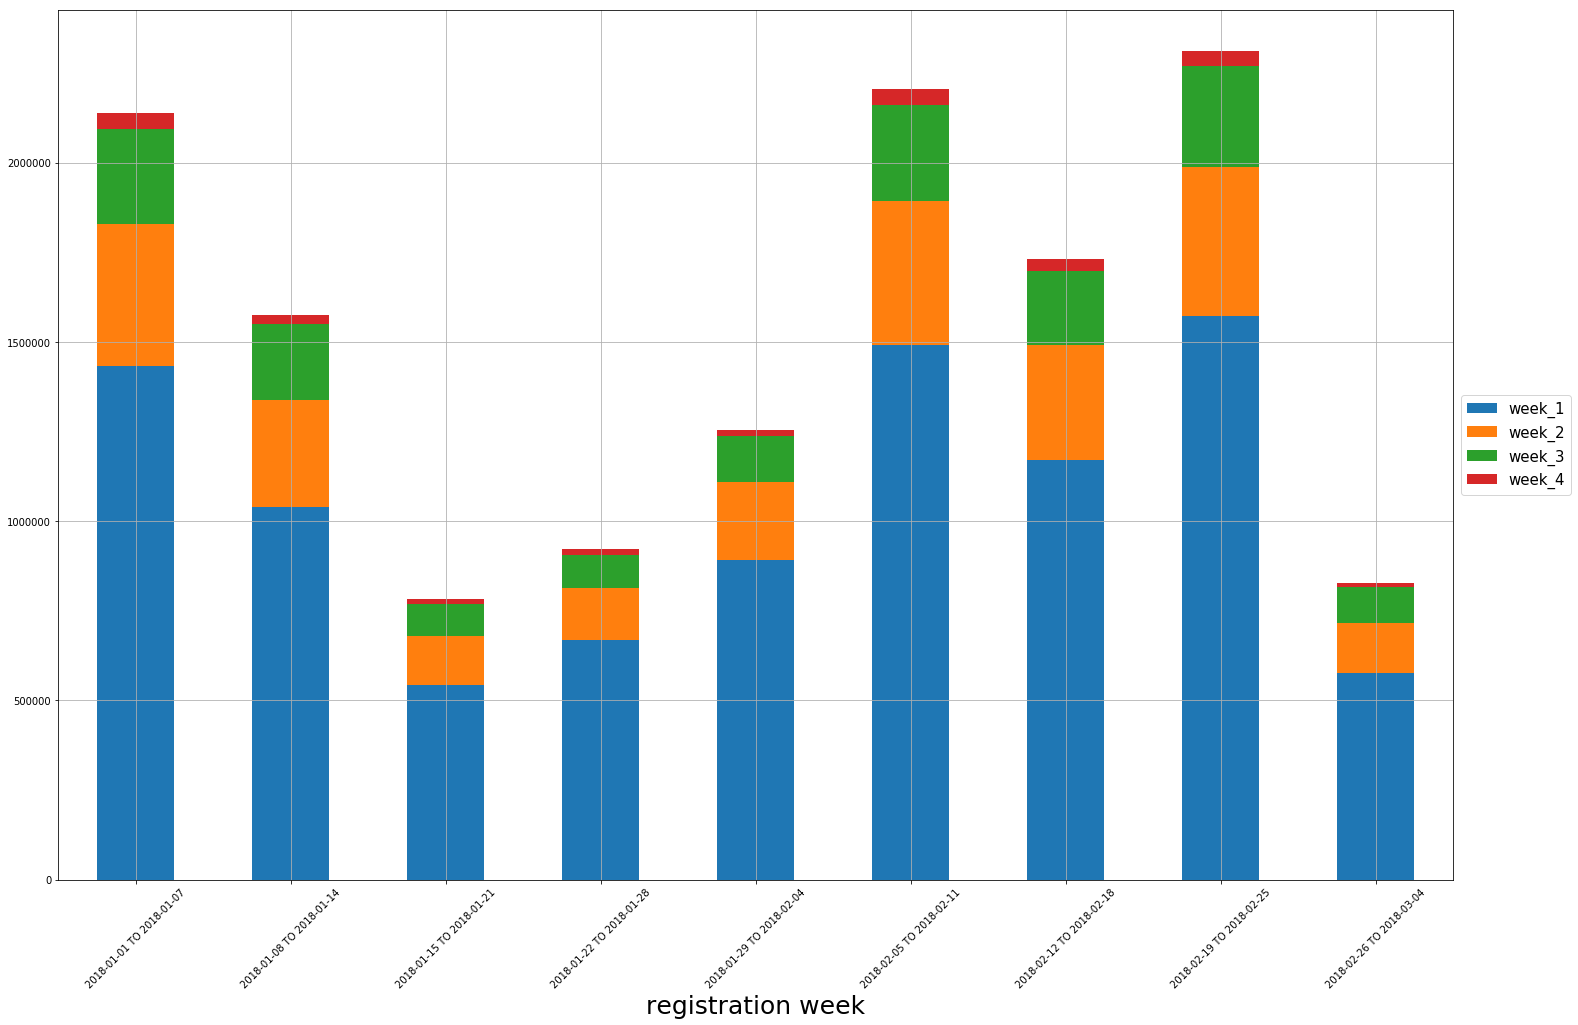

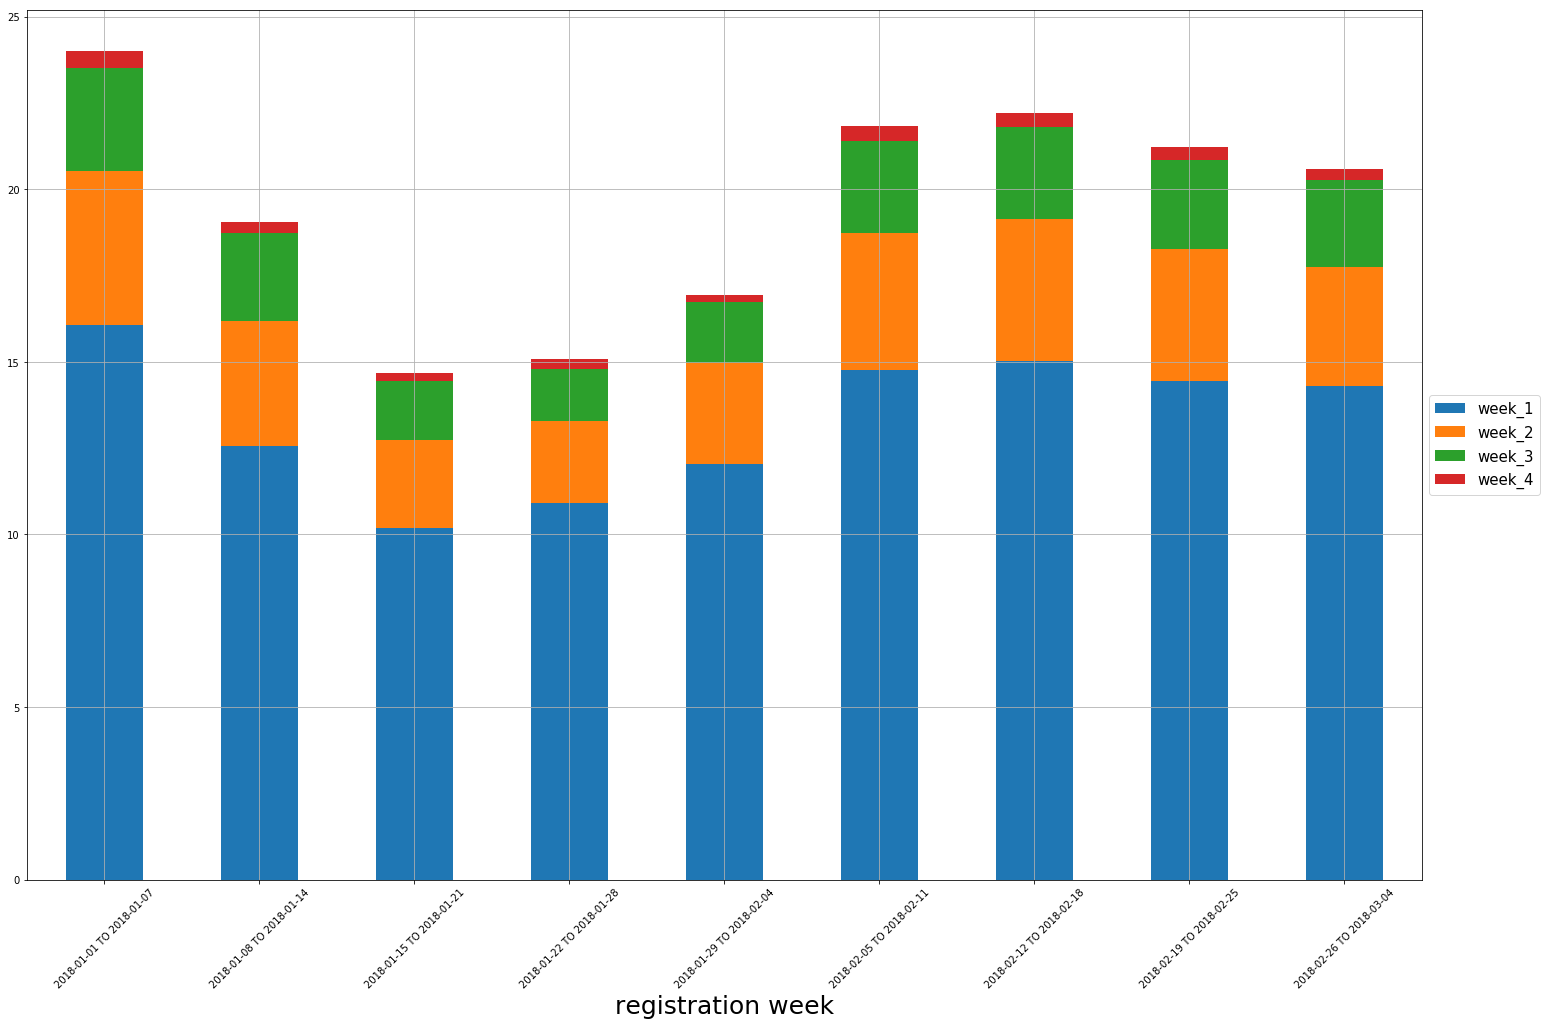

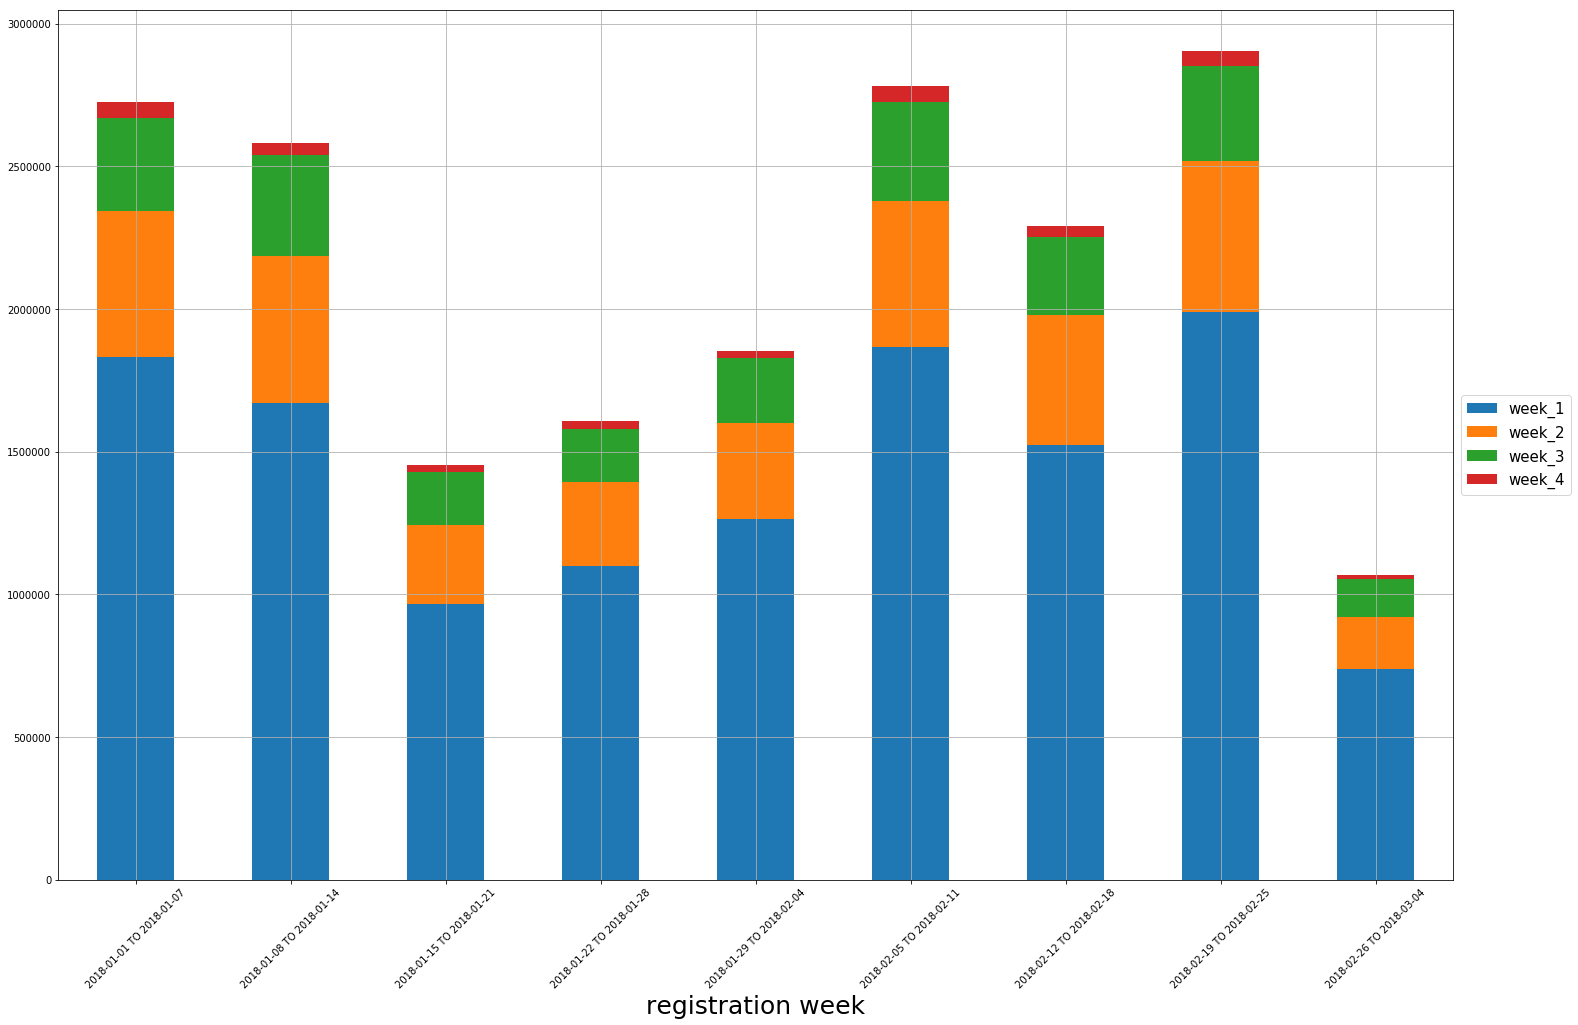

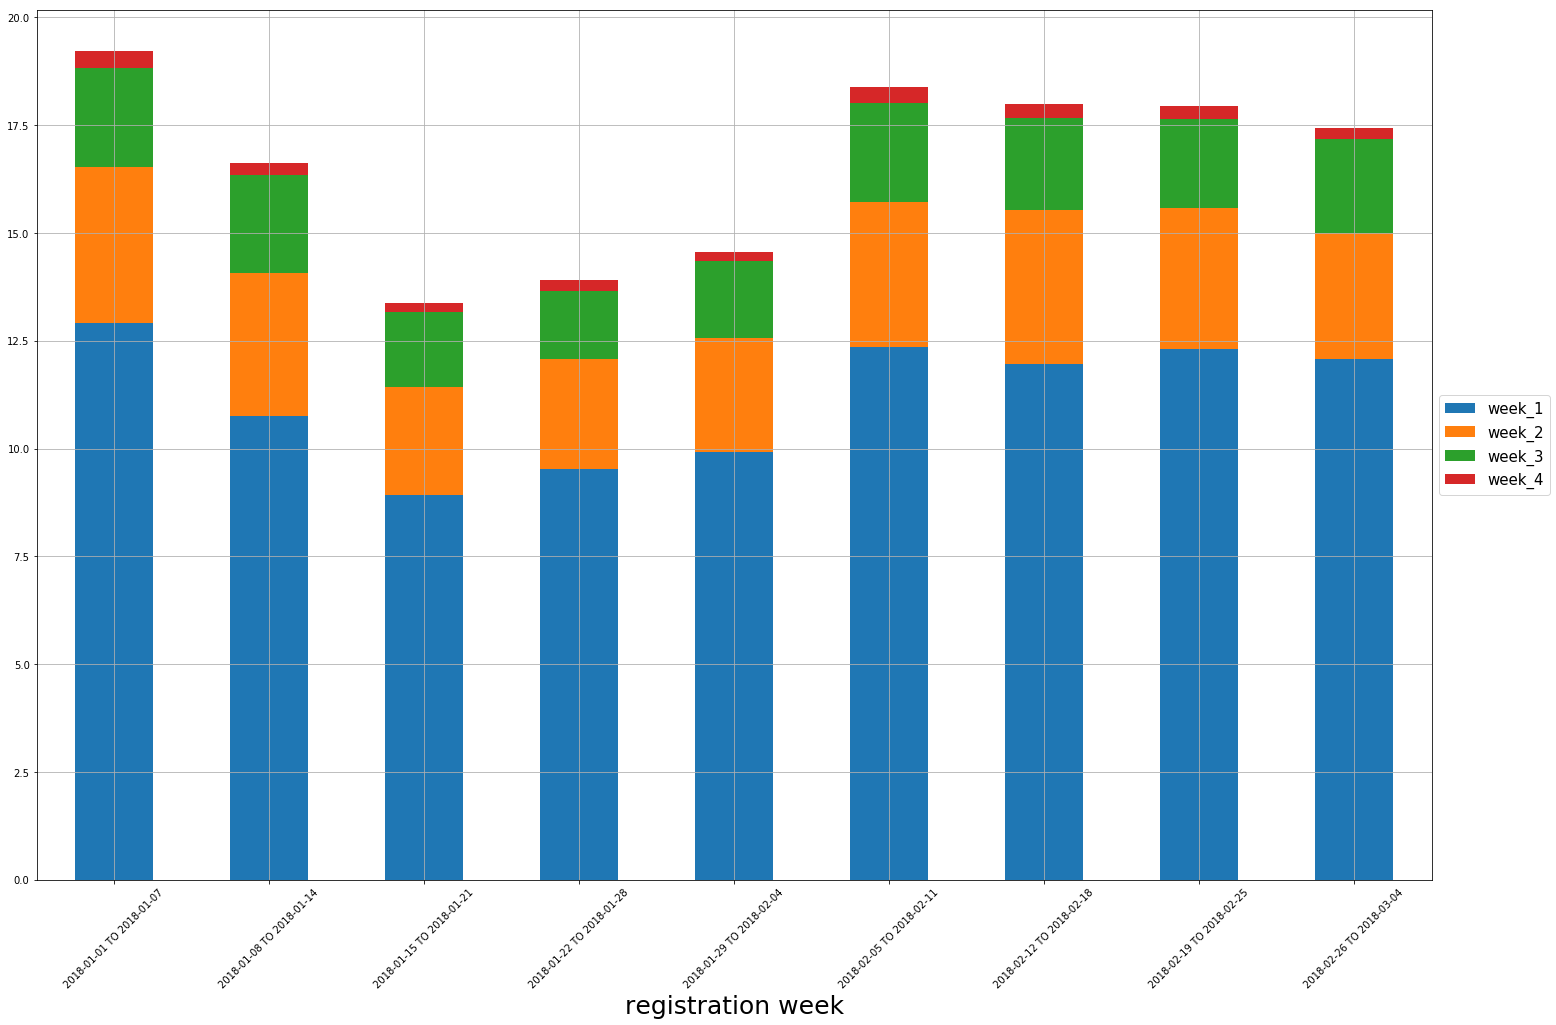

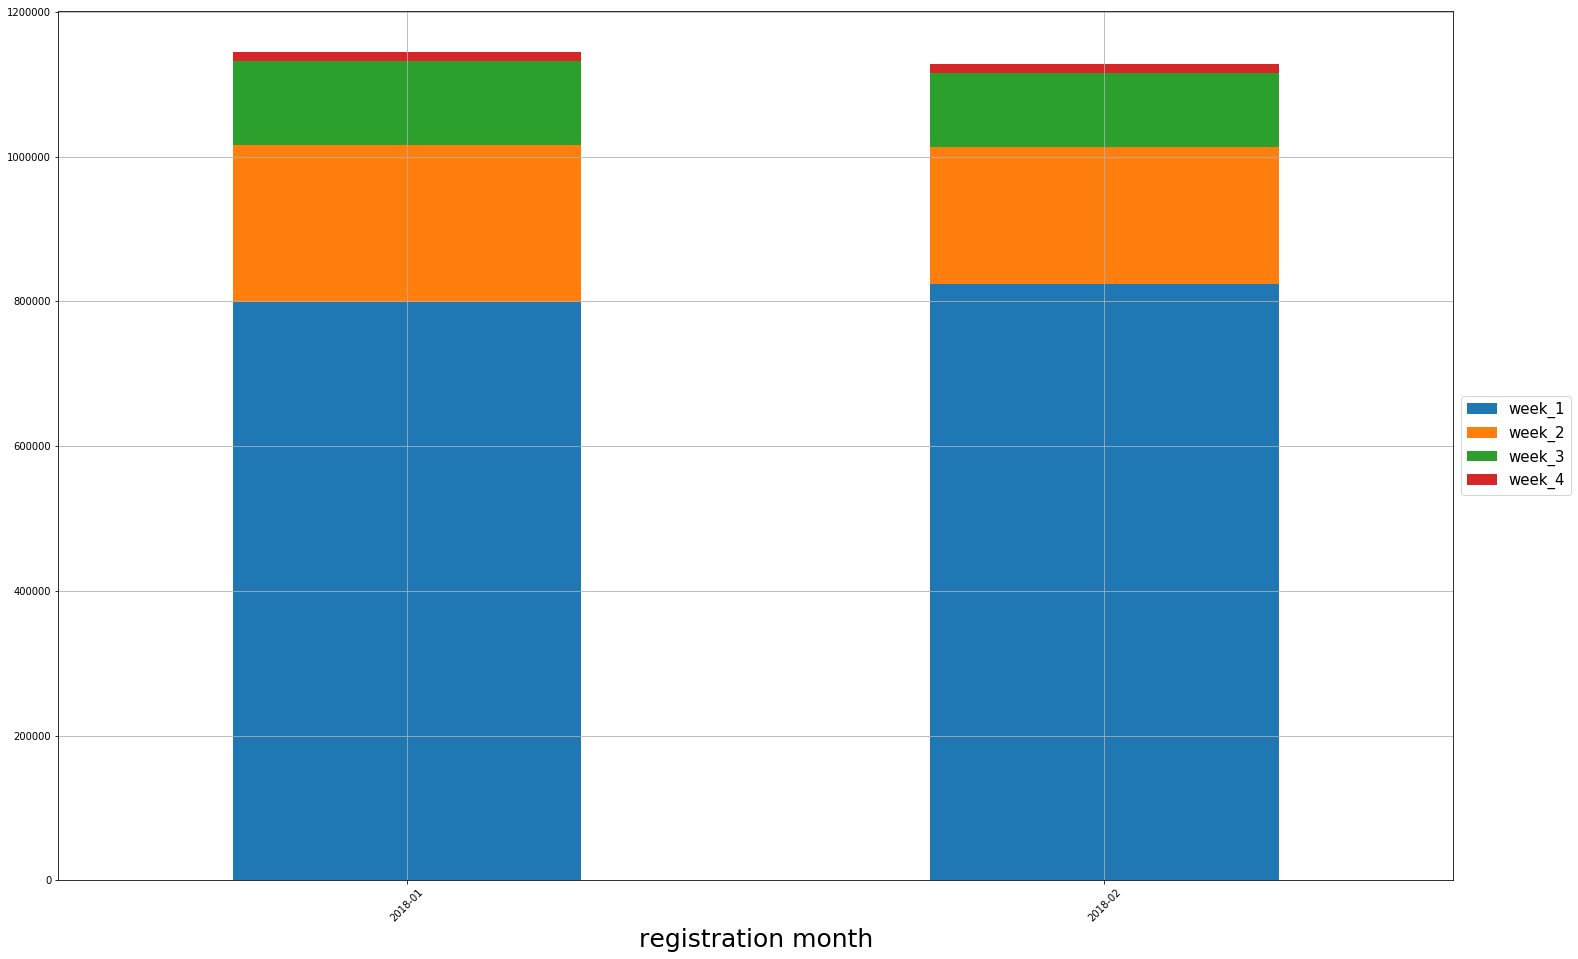

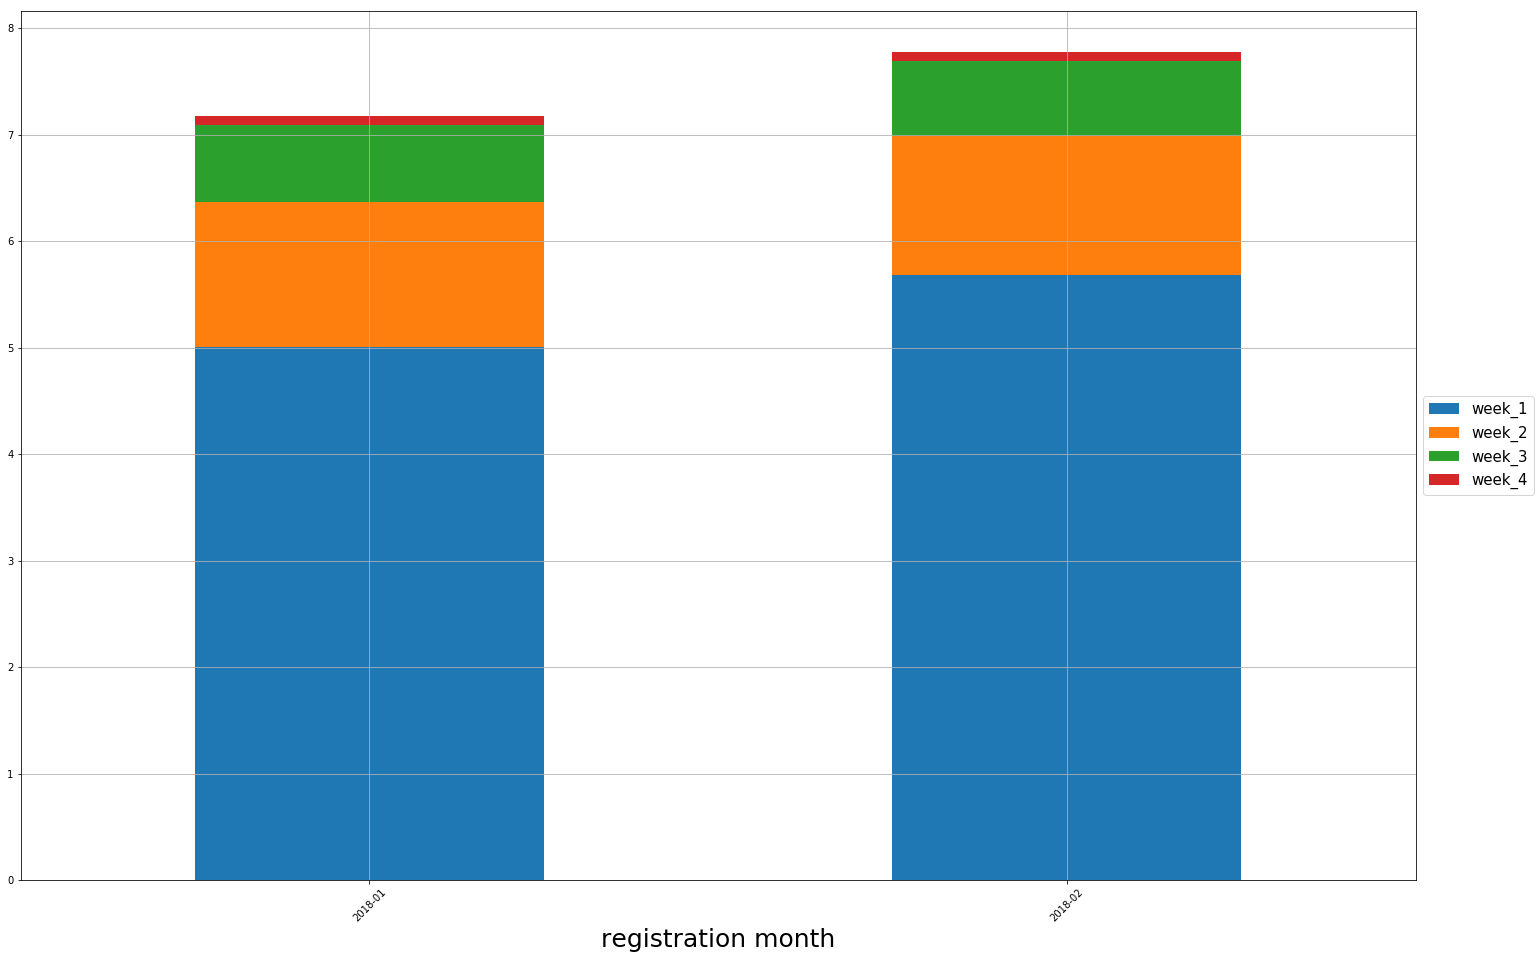

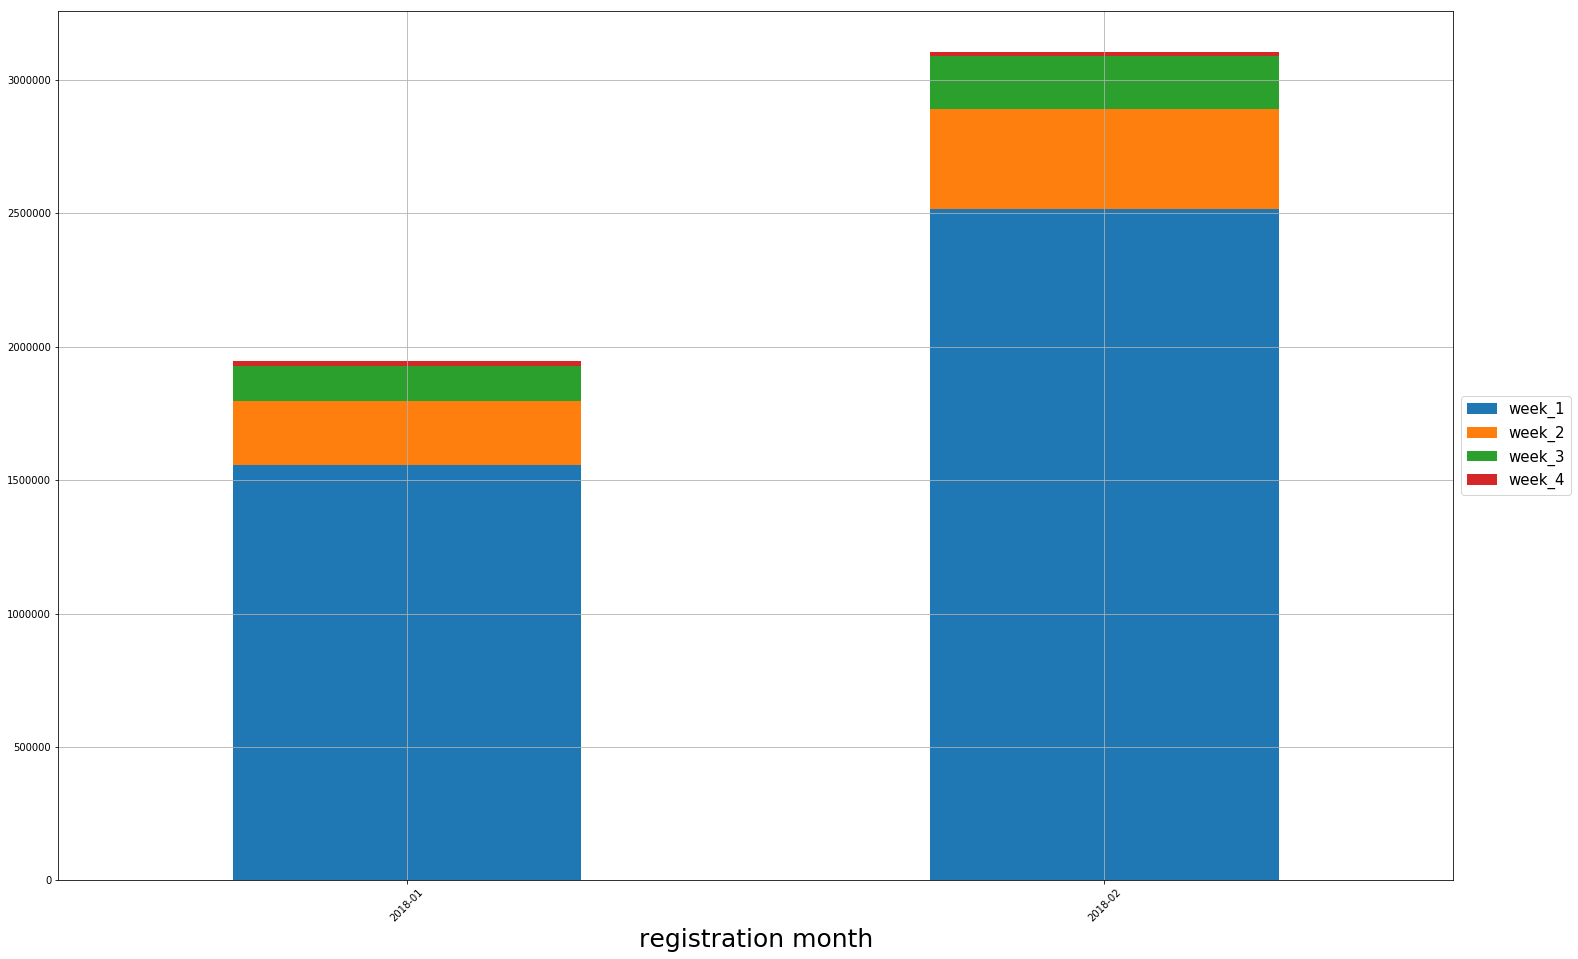

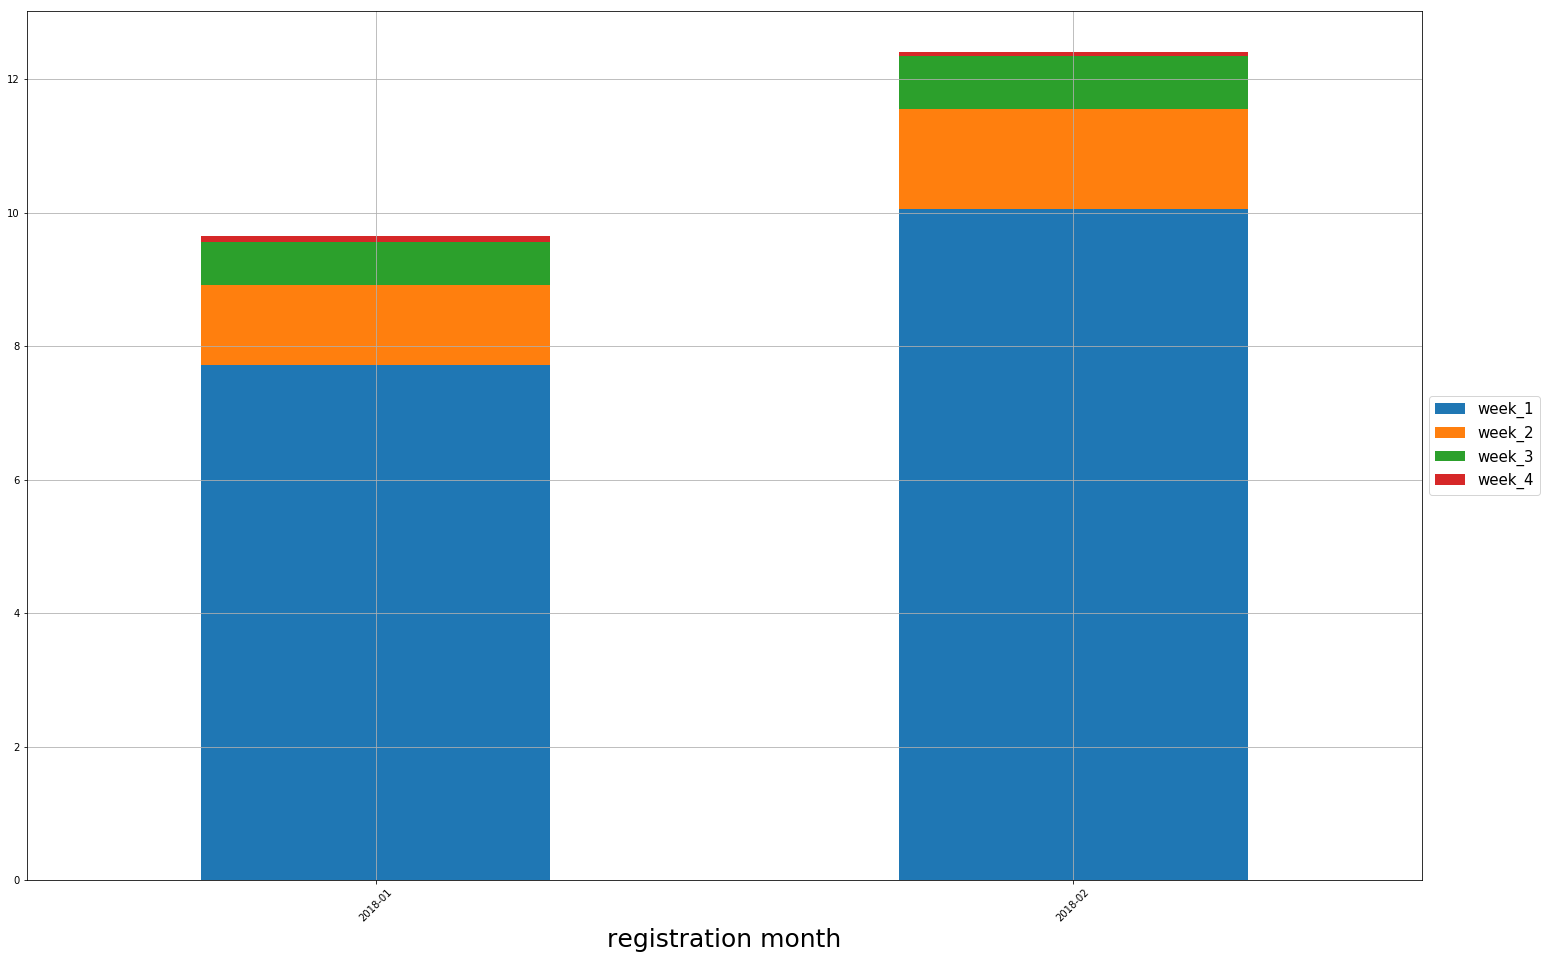

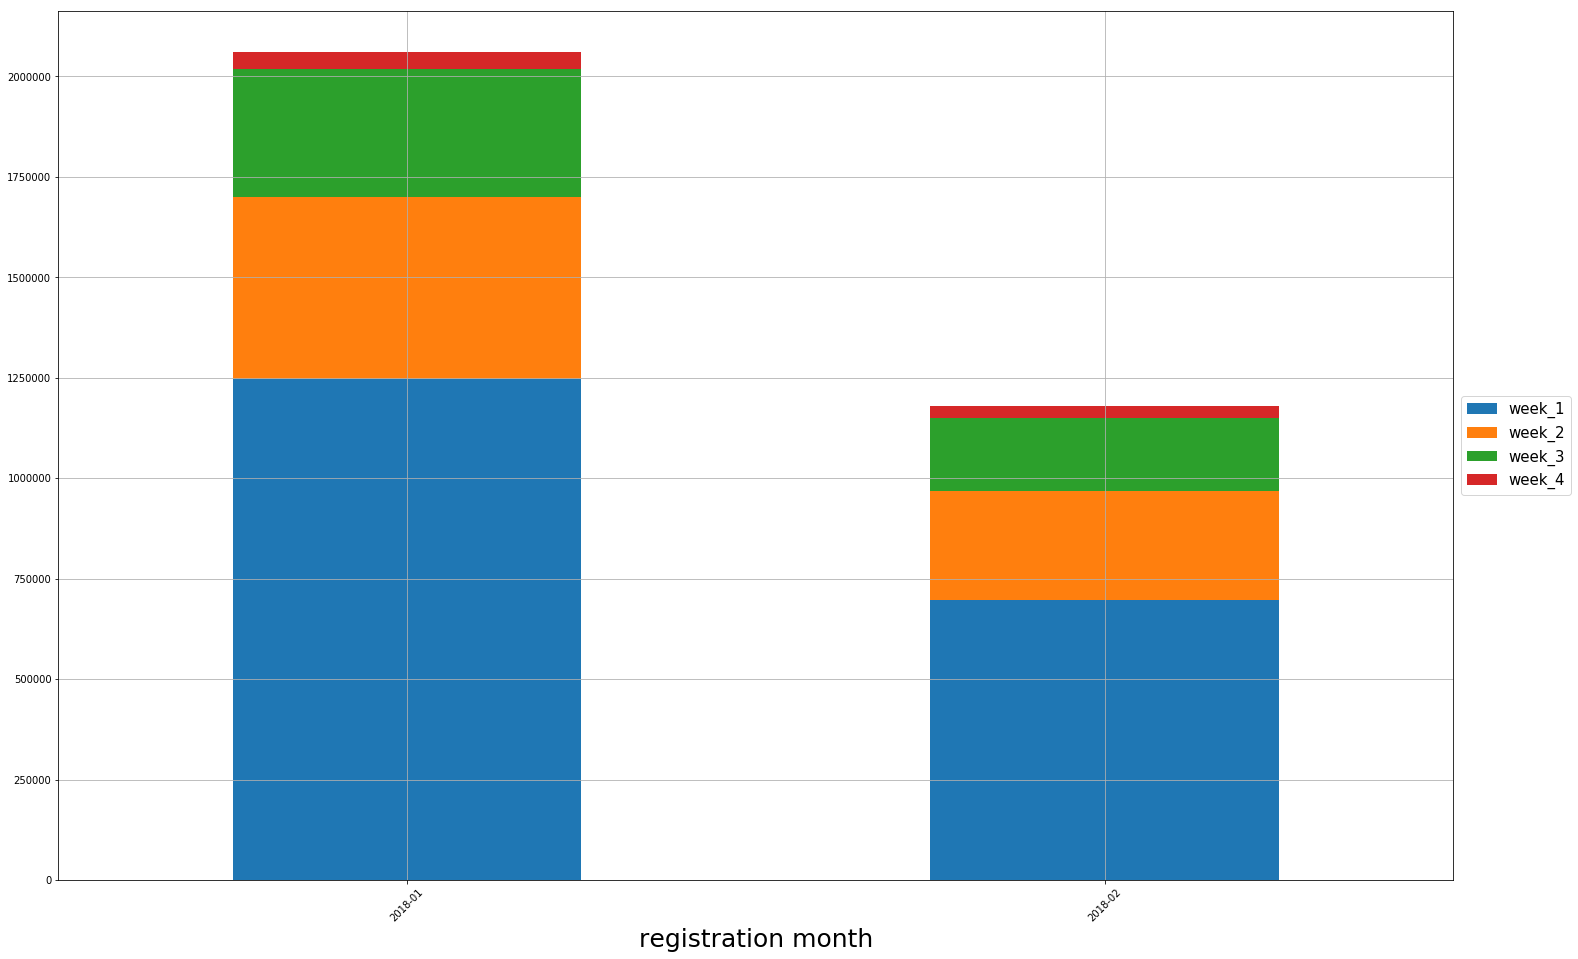

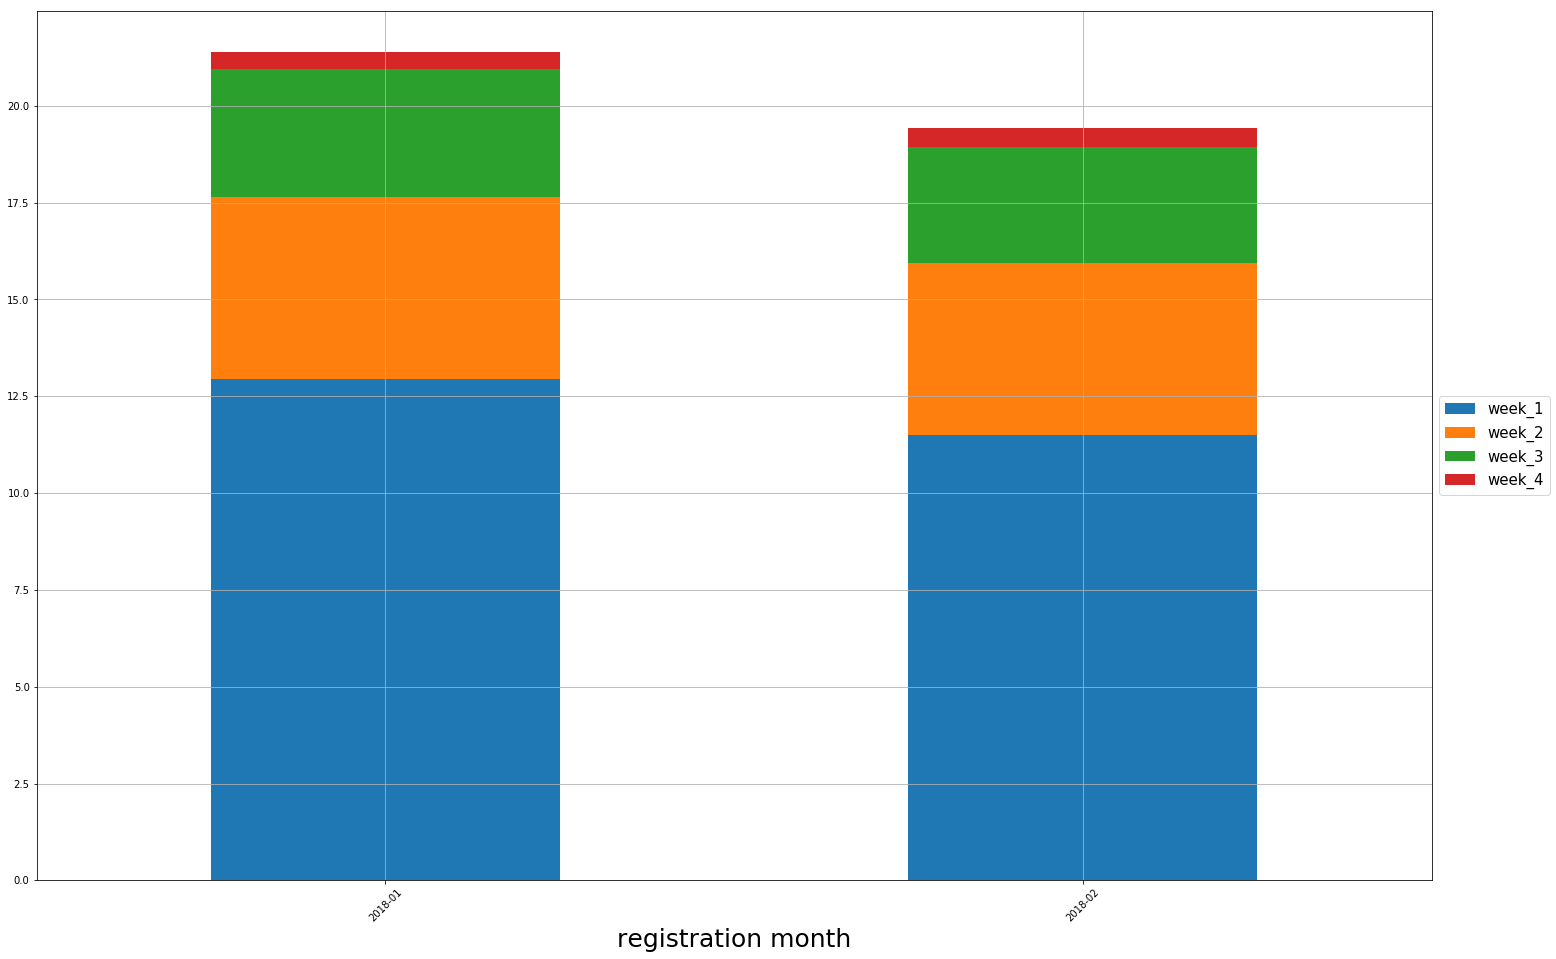

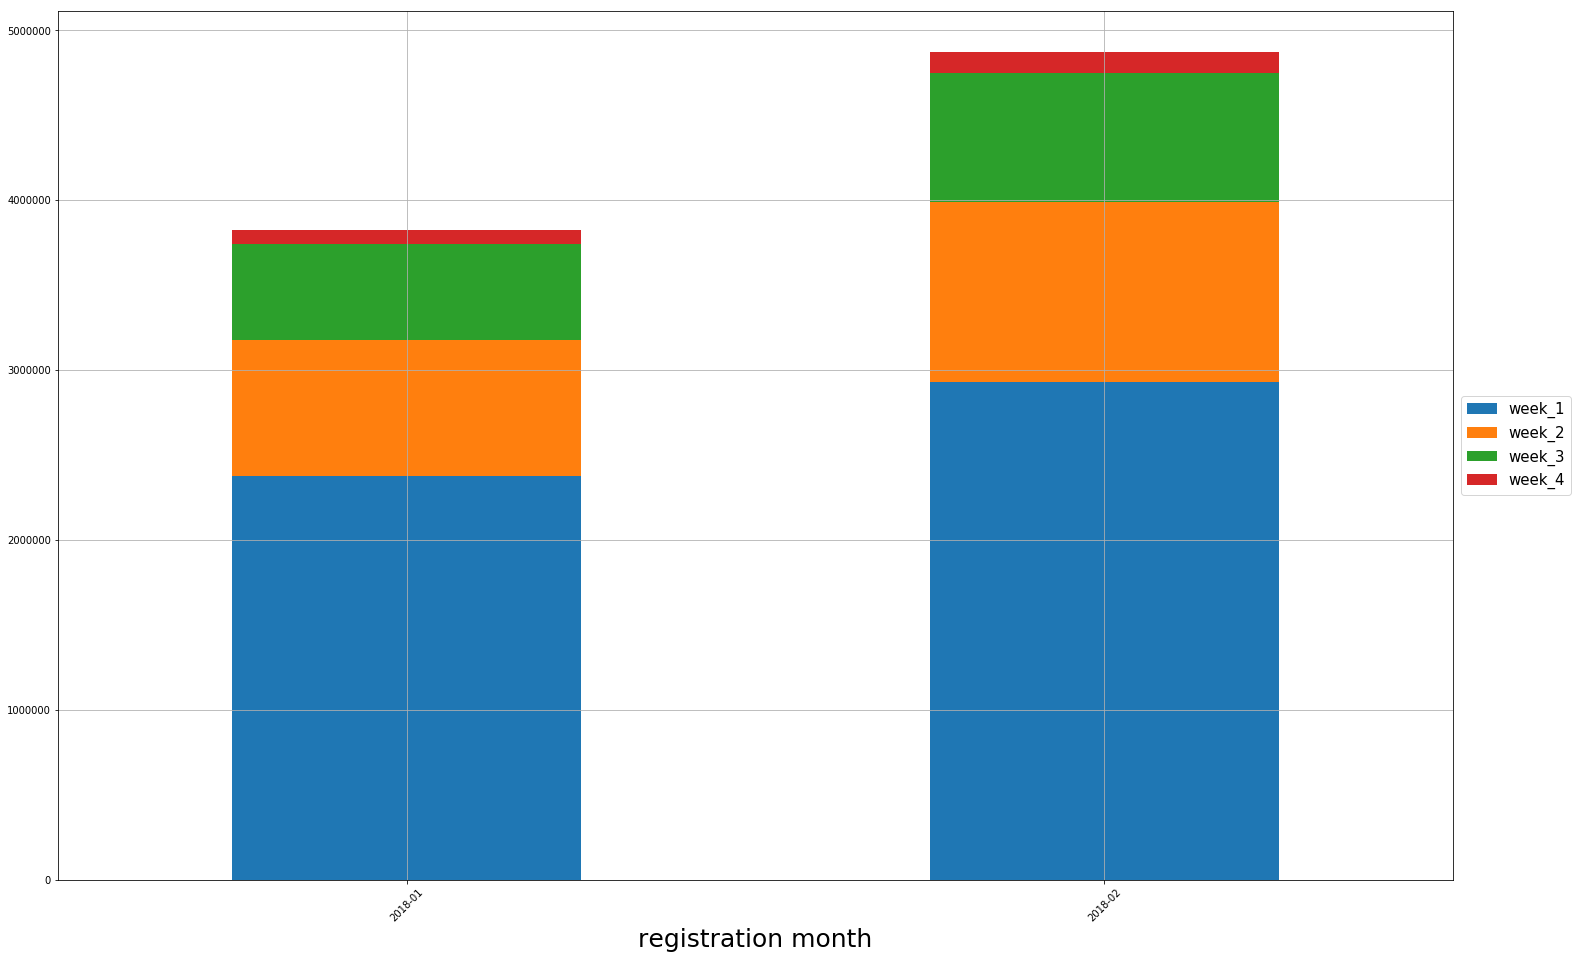

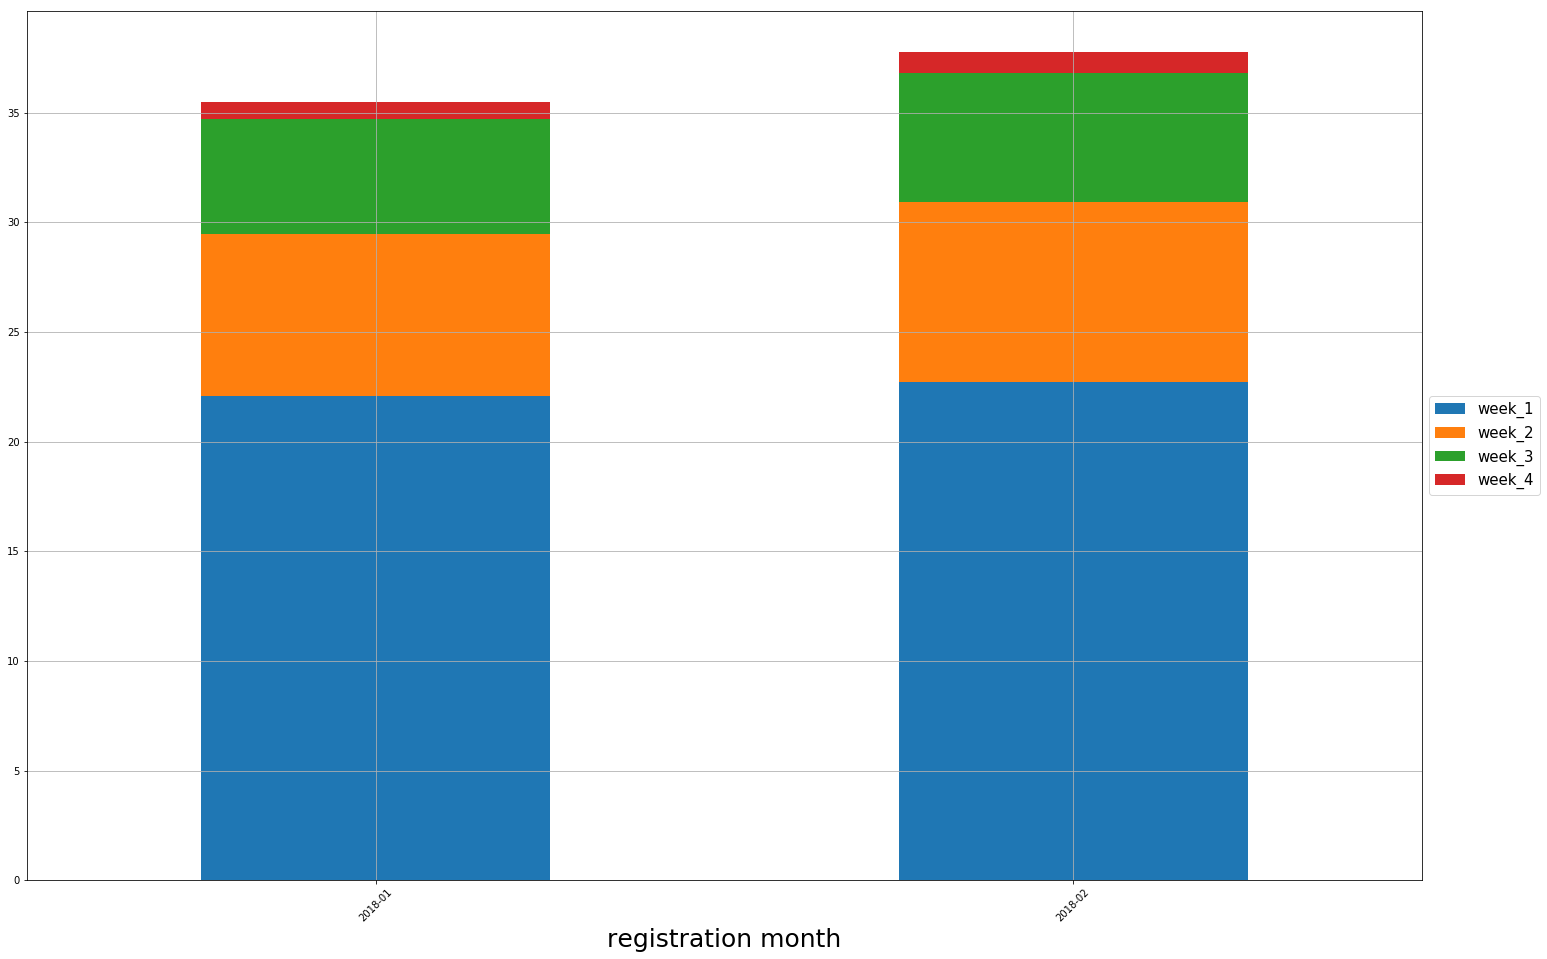

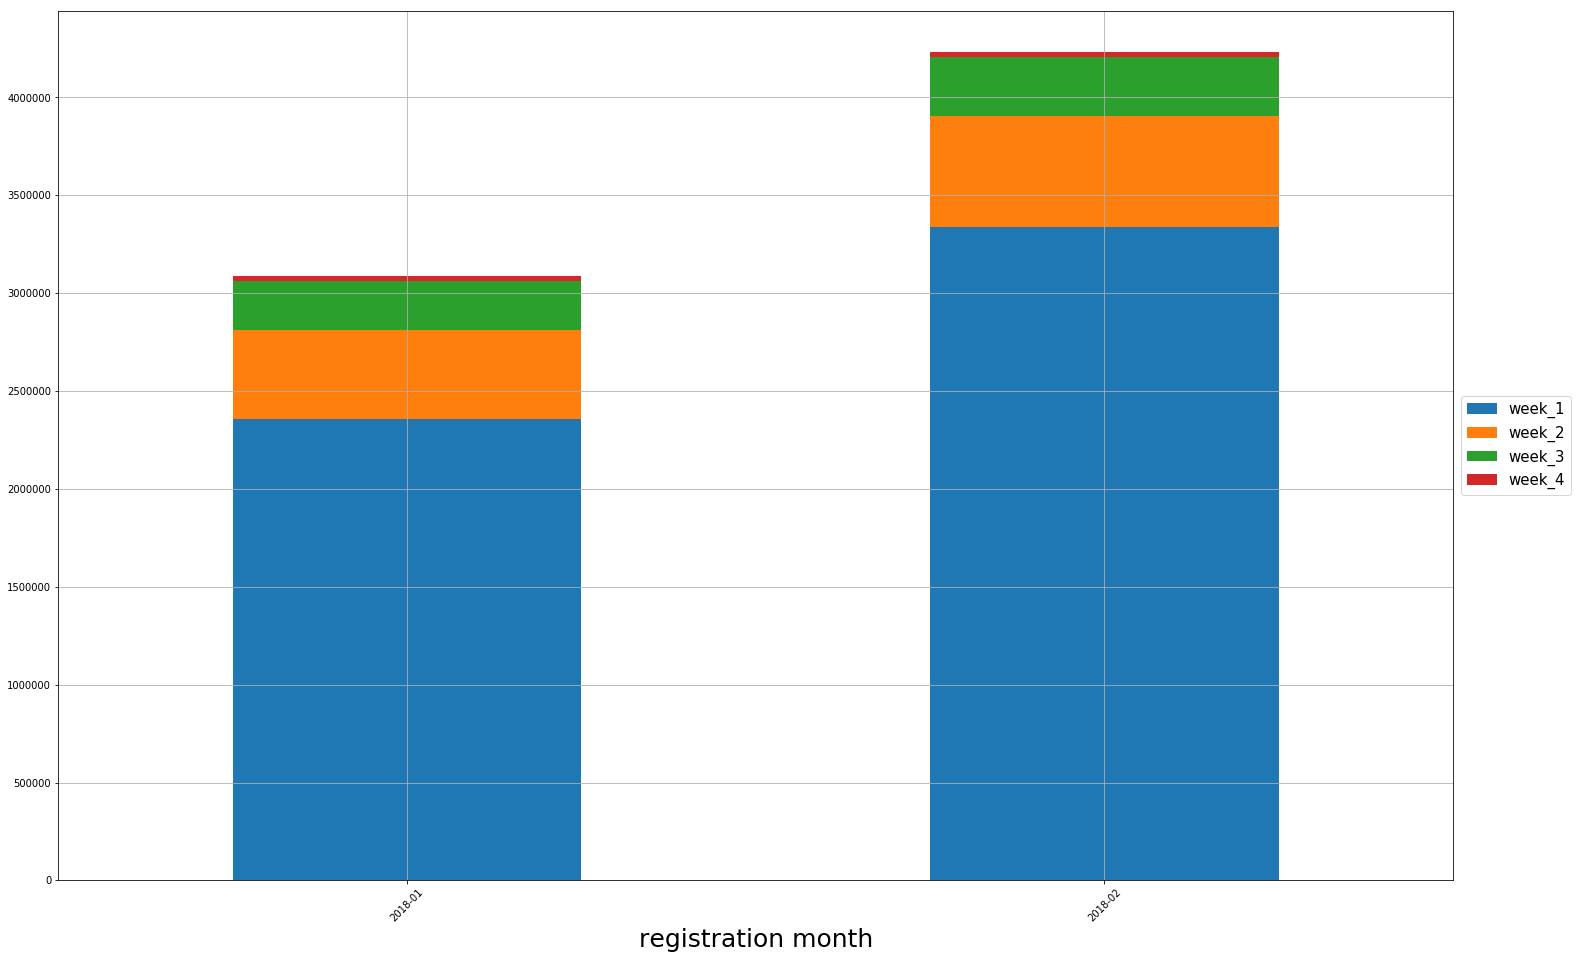

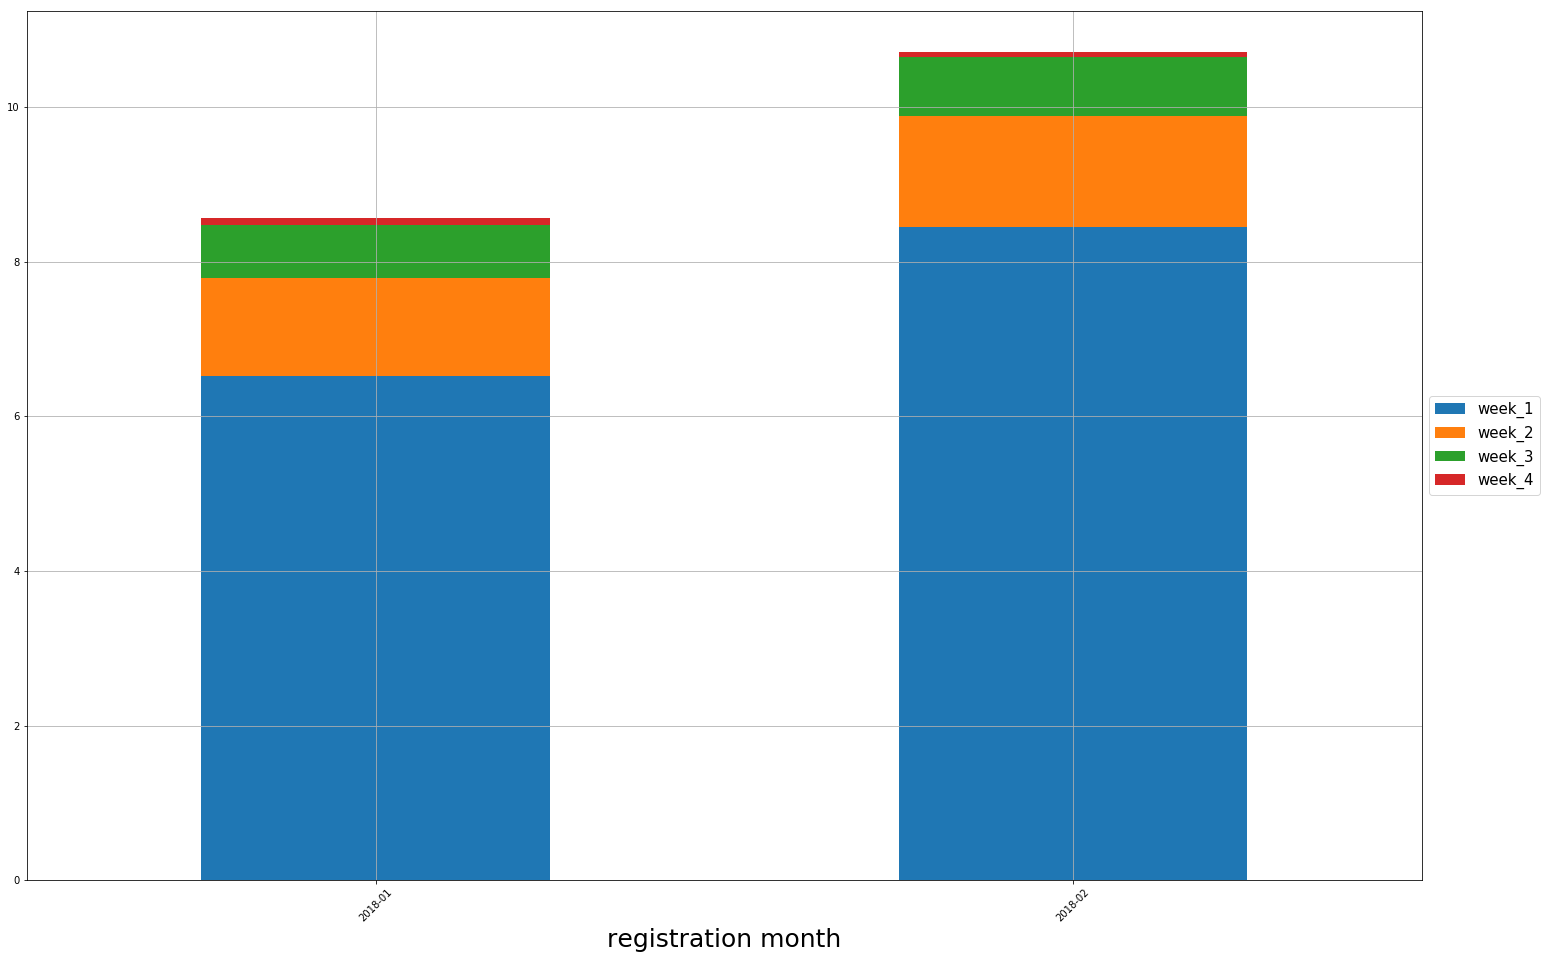

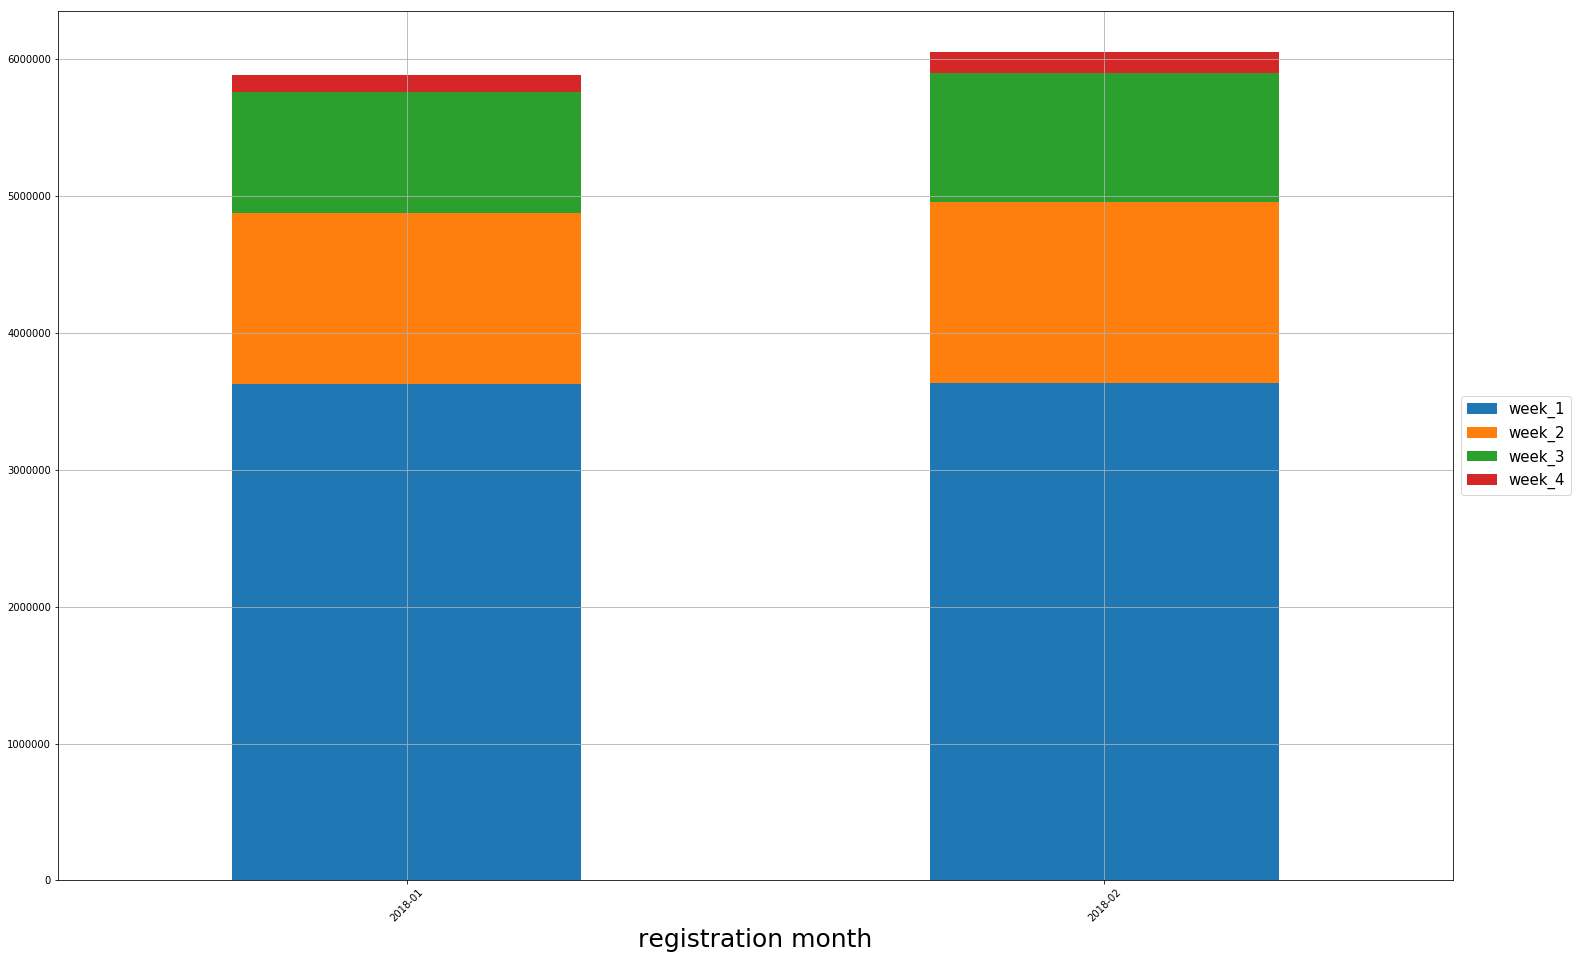

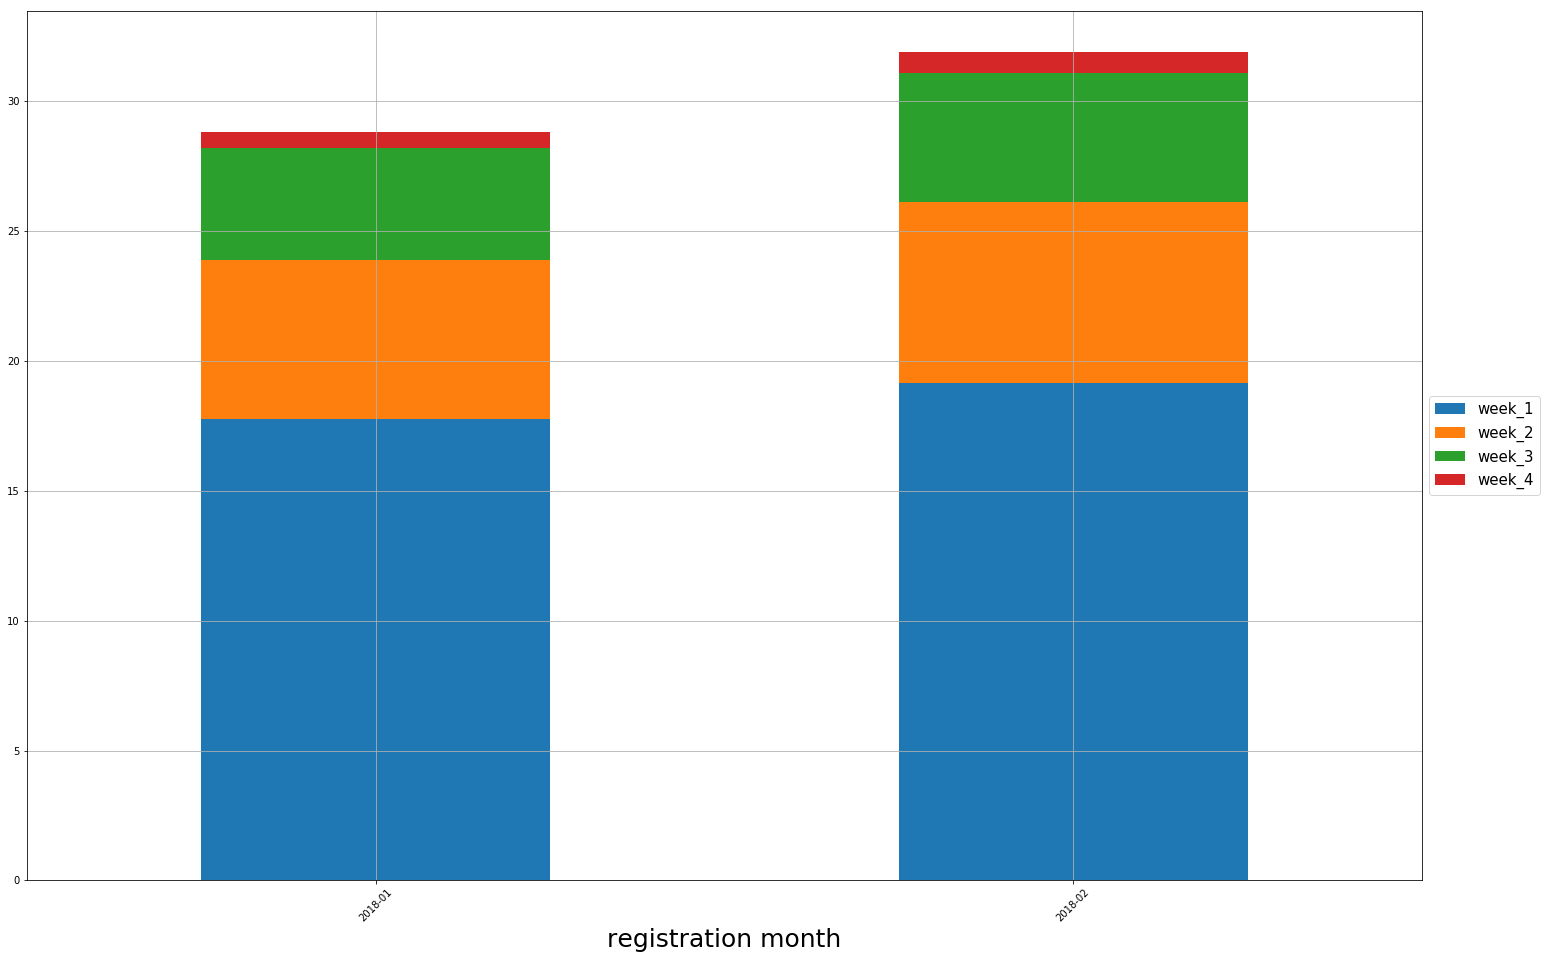

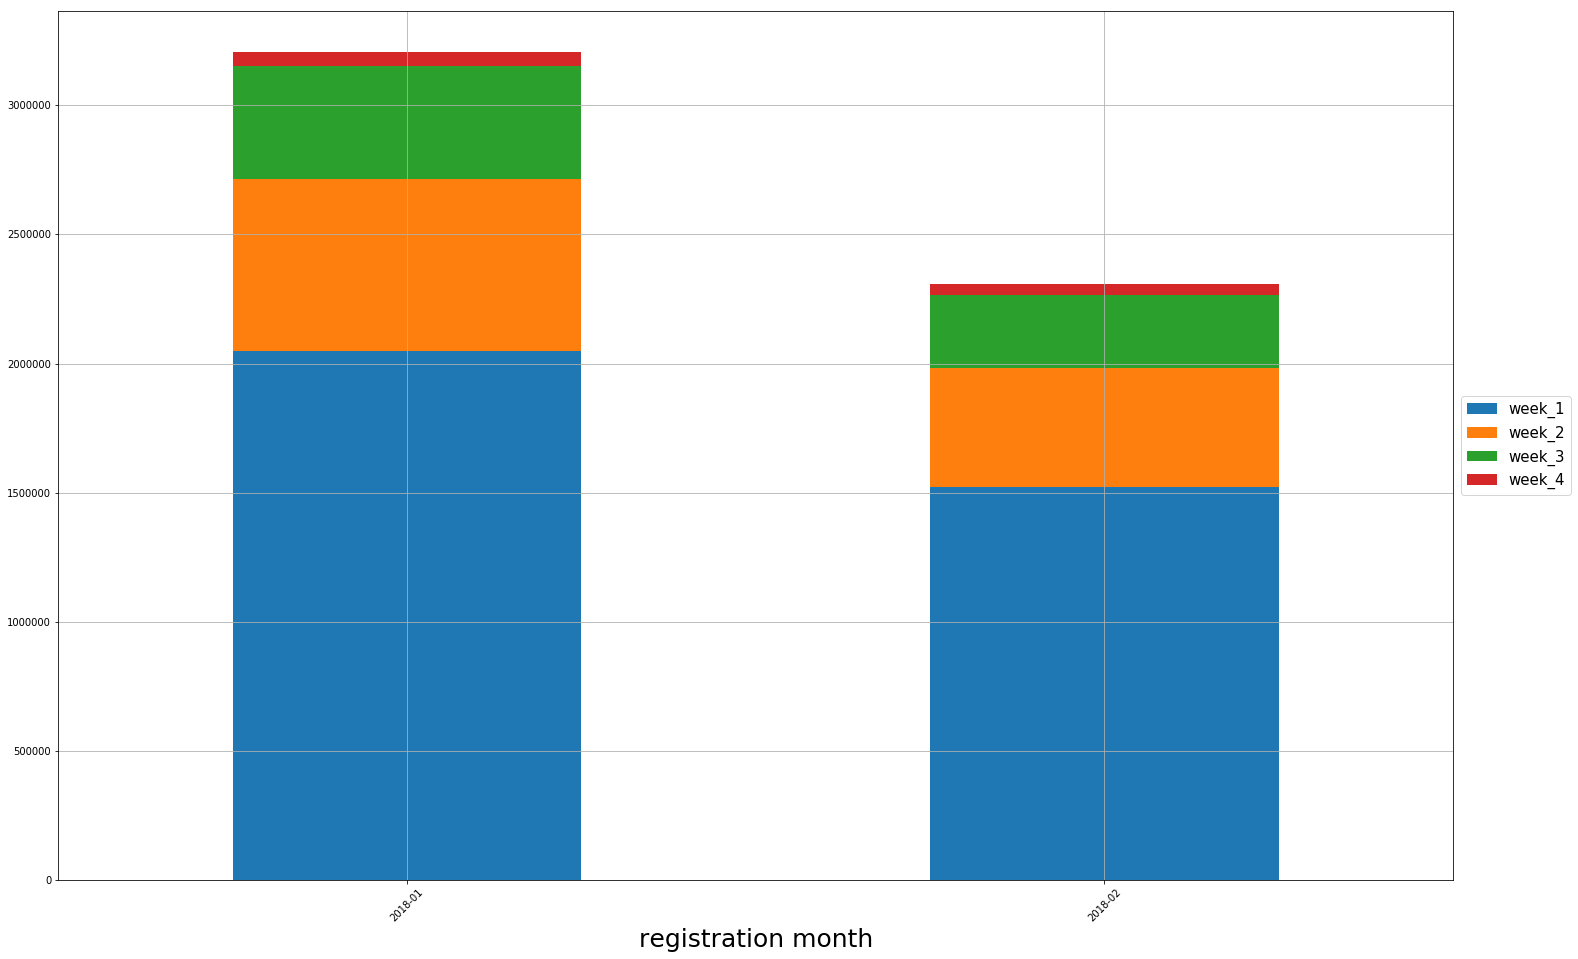

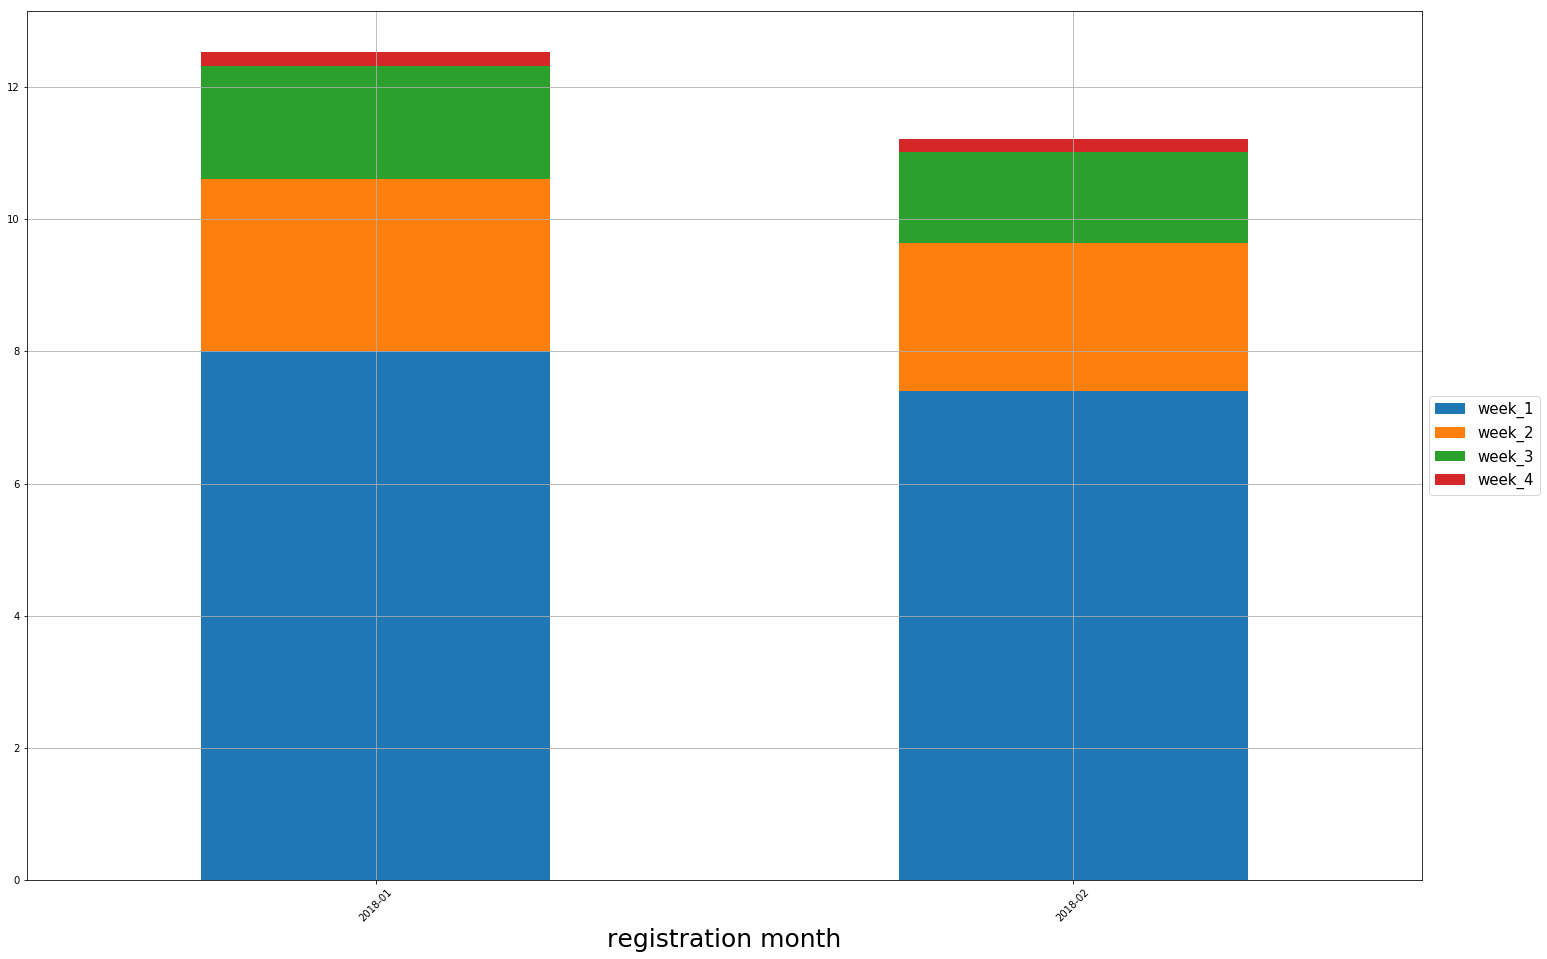

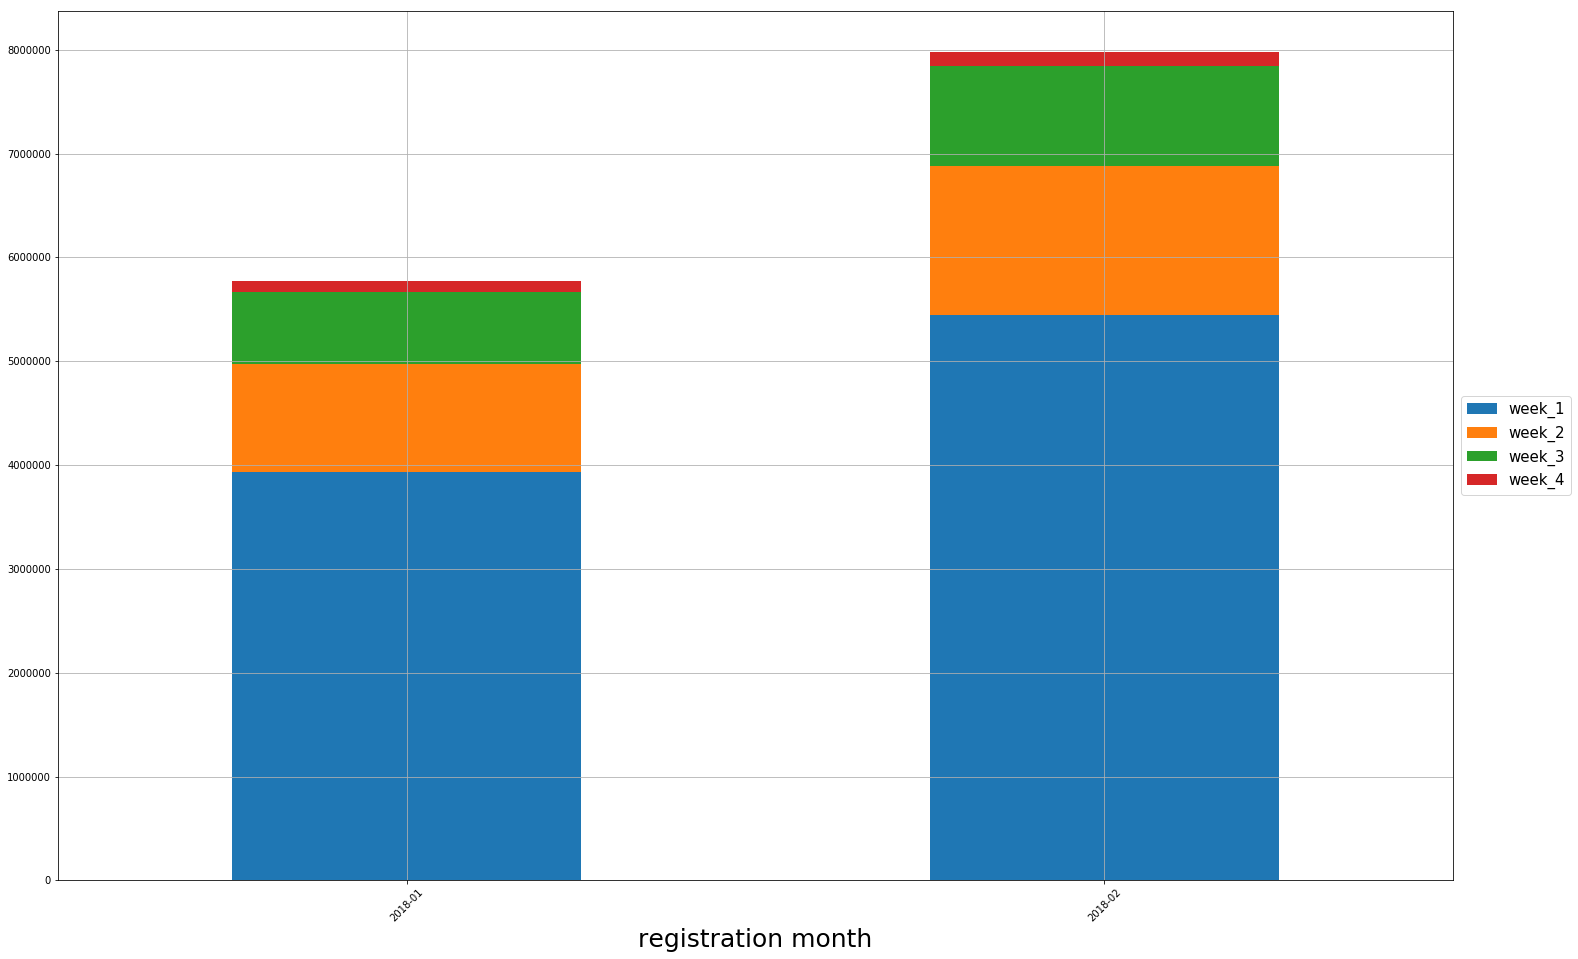

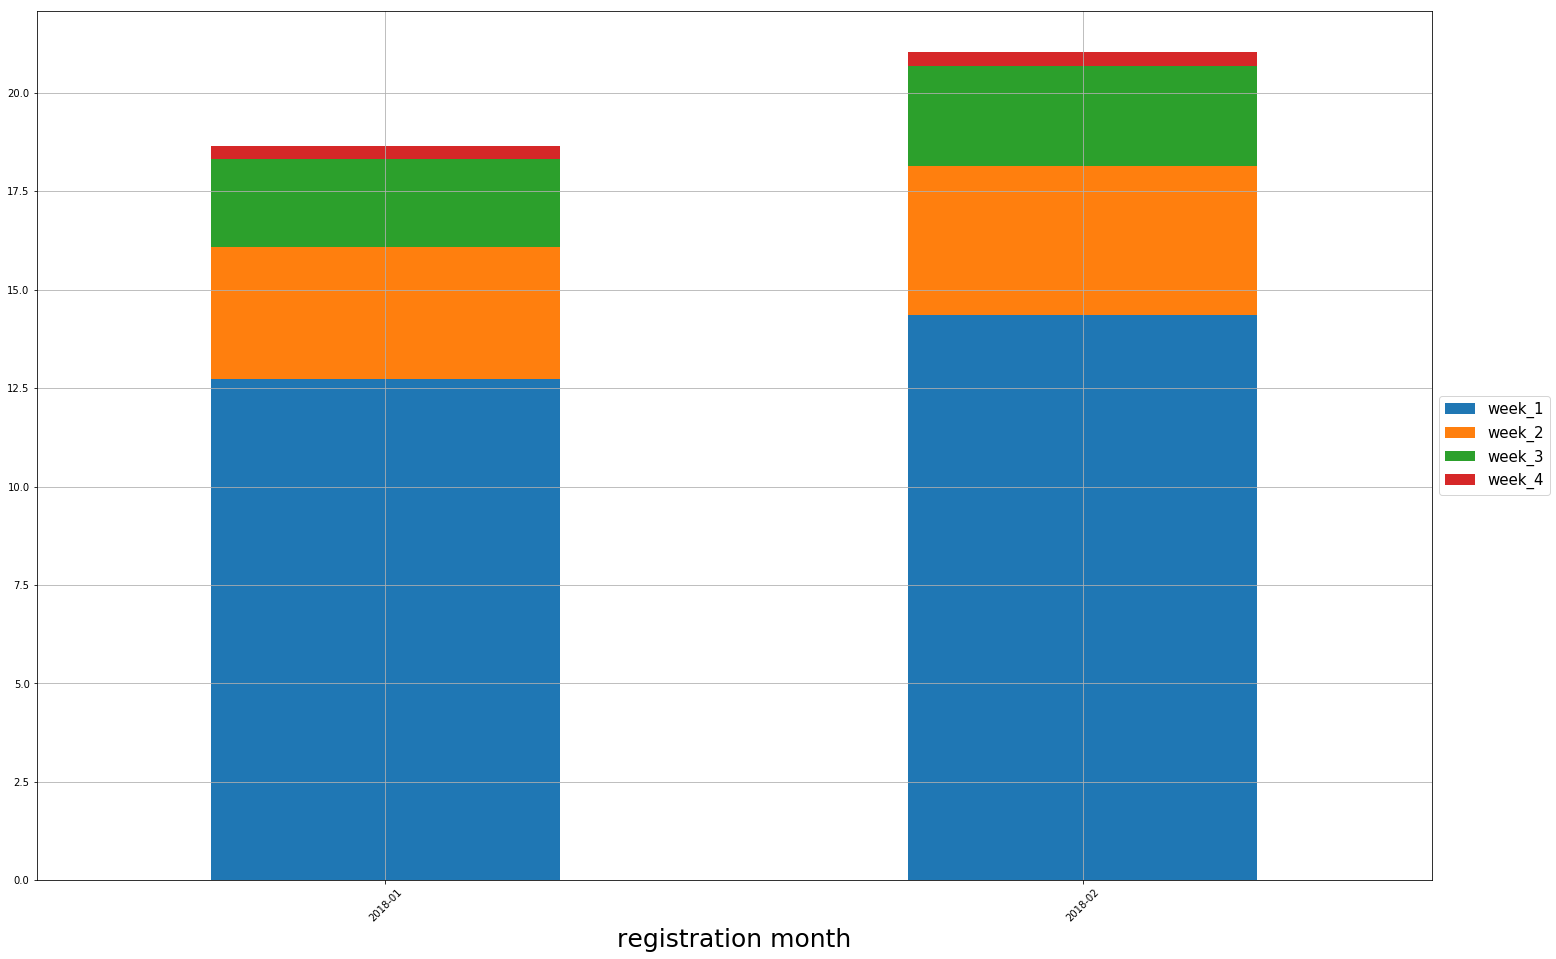

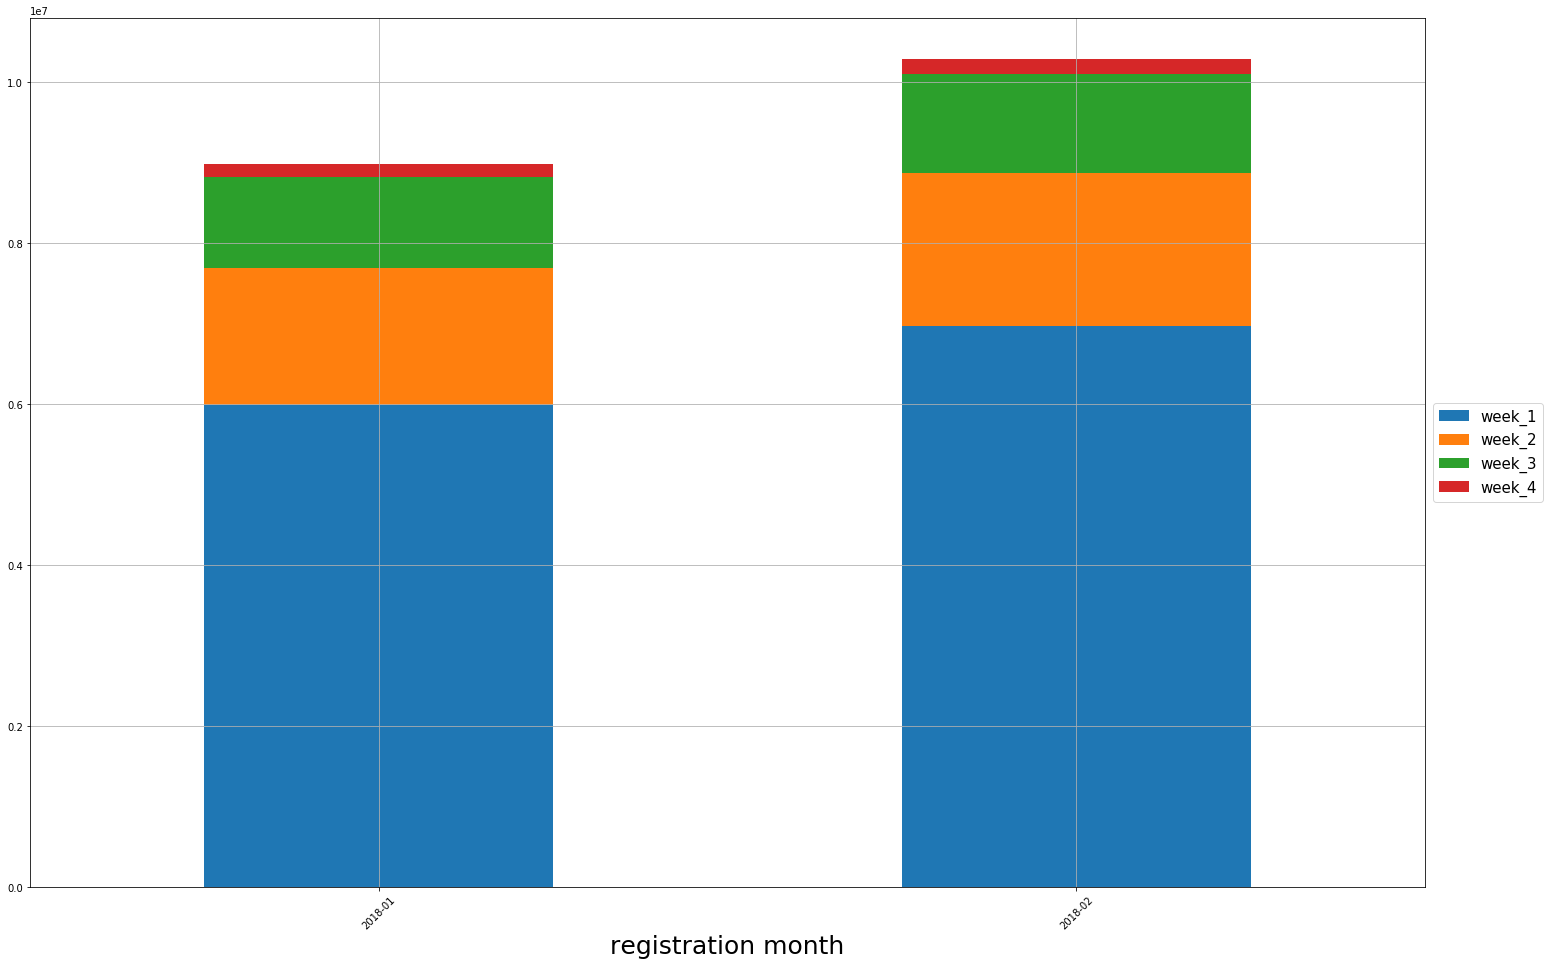

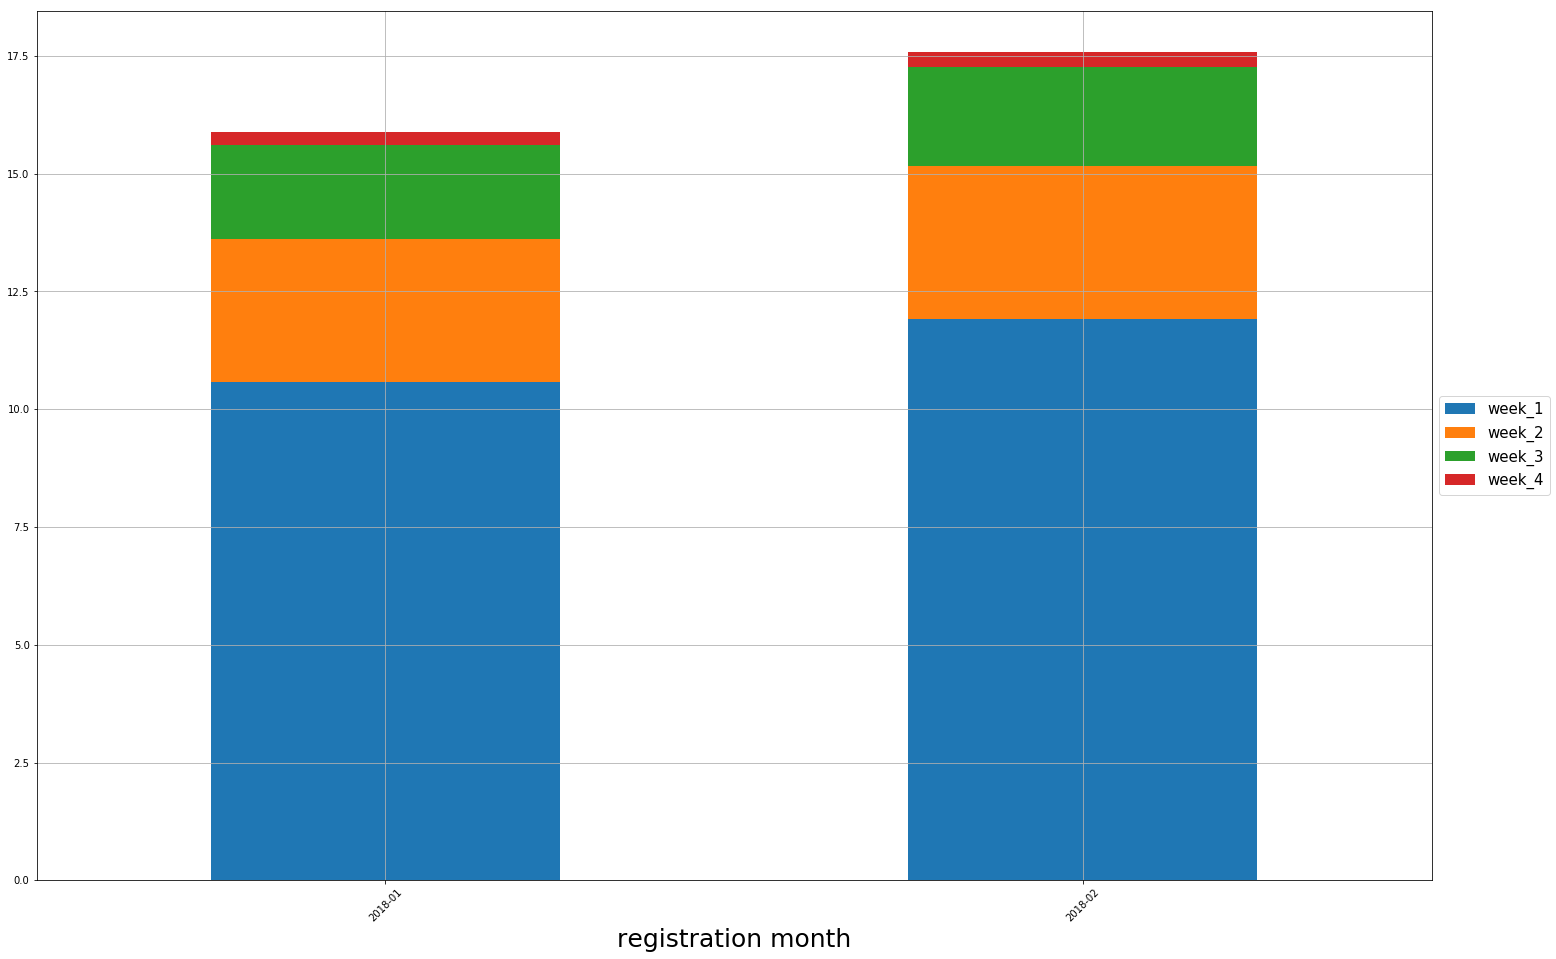

In [16]:
# writer = pd.ExcelWriter('out/revenue_by_months.xlsx')

# for app in ['android','ios']:
#     for ref in ['notref','ref']:
#         df = df_payments[(df_payments['app'] == app) & (df_payments['ref'] == ref)]
#         df_installs = df_installs_all[(df_installs_all['app'] == app) & (df_installs_all['ref'] == ref)]
#         df_installs_2 = df_installs.groupby('created month')['users'].sum()
#         m_revenue = df.pivot_table(index='registration month', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
#         m_revenue.columns = ['week_1','week_2','week_3','week_4']     
#         daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
#         m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
#         daily_metrics.to_excel(writer,'revenue' + ref+'_'+app)
#         m_revenue_normed.to_excel(writer,'revenue_on_regs' + ref+'_'+app)
#         daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
#         vars()['m_revenue_'+ref+'_'+app] = m_revenue
#         vars()['m_revenue_normed_'+ref+'_'+app] = m_revenue_normed
#         vars()['daily_metrics_'+ref+'_'+app] = daily_metrics
        
#         m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img_month/revenue_'+ref+'_'+app+'.png')
        
#         m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img_month/normed_revenue_'+ref+'_'+app+'.png')

# for app in ['android','ios']:
#         df = df_payments[(df_payments['app'] == app)]
#         df_installs = df_installs_all[(df_installs_all['app'] == app)]
#         df_installs_2 = df_installs.groupby('created month')['users'].sum()
#         m_revenue = df.pivot_table(index='registration month', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
#         m_revenue.columns = ['week_1','week_2','week_3','week_4']
#         daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
#         m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
#         daily_metrics.to_excel(writer,'revenue'+'_'+app)
#         m_revenue_normed.to_excel(writer,'revenue_on_regs'+'_'+app)
#         daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
#         vars()['m_revenue_'+app] = m_revenue
#         vars()['m_revenue_normed_'+app] = m_revenue_normed
#         vars()['daily_metrics_'+app] = daily_metrics
        
#         m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img_month/revenue_'+app+'.png')
        
#         m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img_month/normed_revenue_'+app+'.png')
        
# for ref in ['notref','ref']:
#         df = df_payments[(df_payments['ref'] == ref)]
#         df_installs = df_installs_all[(df_installs_all['ref'] == ref)]
#         df_installs_2 = df_installs.groupby('created month')['users'].sum()
#         m_revenue = df.pivot_table(index='registration month', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
#         m_revenue.columns = ['week_1','week_2','week_3','week_4']
#         daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
#         m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
#         daily_metrics.to_excel(writer,'revenue'+'_'+ref)
#         m_revenue_normed.to_excel(writer,'revenue_on_regs'+'_'+ref)
#         daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
#         vars()['m_revenue_'+ref] = m_revenue
#         vars()['m_revenue_normed_'+ref] = m_revenue_normed
#         vars()['daily_metrics_'+ref] = daily_metrics
        
#         m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img_month/revenue_'+ref+'.png')
        
#         m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#         plt.savefig('img_month/normed_revenue_'+ref+'.png')
        
# df = df_payments
# df_installs = df_installs_all
# df_installs_2 = df_installs.groupby('created month')['users'].sum()
# m_revenue = df.pivot_table(index='registration month', columns='weeks from reg', values='revenue in cents', aggfunc=sum).fillna(0).applymap(float)
# m_revenue.columns = ['week_1','week_2','week_3','week_4']
# daily_metrics = pd.concat([m_revenue, df_installs_2], join='outer', axis = 1)
# m_revenue_normed = m_revenue.divide(daily_metrics['users'], axis='index')
# daily_metrics.to_excel(writer,'revenue')
# m_revenue_normed.to_excel(writer,'revenue_on_regs')
# daily_metrics.columns = ['week_1','week_2','week_3','week_4','users']
        
# vars()['m_revenue'] = m_revenue
# vars()['m_revenue_normed'] = m_revenue_normed
# vars()['daily_metrics'] = daily_metrics
        
# m_revenue.groupby(m_revenue.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par);
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.savefig('img_month/revenue.png')
        
# m_revenue_normed.groupby(m_revenue_normed.index).sum().plot(kind='bar', rot=45, stacked=True, grid = True, figsize = (25,16), fontsize = fontsize_par).legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
# plt.savefig('img_month/normed_revenue.png')

# writer.save()